In [1]:
import re, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import time 
from tqdm import tqdm
import torch

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from datasets import load_dataset
from functools import partial
import multiprocessing as mp

from rouge_score import rouge_scorer
import pandas as pd
from operator import itemgetter

#from base_model import MultiHeadSelfAttention
from torch import nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
import pytorch_lightning as pl
from torchmetrics import F1Score
from torch import optim

#from data_loaders import DocumentDataset
from torch_geometric.data import DataLoader, Dataset
from eval_models import retrieve_parameters, eval_results, filtering_matrices

from preprocess_data import load_data
#from summarization_utils import create_dataframe, clean_tokenization_sent
from base_model import MHASummarizer_extended, MHASummarizer
from data_loaders import create_loaders, clean_tokenization_sent, check_dataframe, get_class_weights

os.environ["TOKENIZERS_PARALLELISM"] = "False"
os.environ["CUDA_VISIBLE_DEVICES"]='5'									

### Training MHA

In [2]:
#data_paths:
in_path = "/scratch/datasets/GovReport-Sum/"
data_train = None
labels_train = None
data_test = None
labels_test = None

df_train, df_val, df_test = load_data(in_path, data_train, labels_train, data_test, labels_test, with_val=True)

print ("df_train", df_train.shape)
print ("df_val", df_val.shape)
print ("df_test", df_test.shape)

Loading from Processed folder
df_train (17484, 4)
df_val (971, 4)
df_test (972, 4)


In [3]:
print("\nChecking train")
ids2remove_train= check_dataframe(df_train)
for id_remove in ids2remove_train:
    df_train = df_train.drop(id_remove)    
df_train.reset_index(drop=True, inplace=True)
print ("Train shape:", df_train.shape)

print("\nChecking val")
ids2remove_val = check_dataframe(df_val)
for id_remove in ids2remove_val:
    df_val = df_val.drop(id_remove)    
df_val.reset_index(drop=True, inplace=True)
print ("Val shape:", df_val.shape)

print("\nChecking test")  
ids2remove_test = check_dataframe(df_test)
for id_remove in ids2remove_test:
    df_test = df_test.drop(id_remove)    
df_test.reset_index(drop=True, inplace=True)
print ("Test shape:", df_test.shape)


Checking train
Train shape: (17482, 4)

Checking val
Val shape: (970, 4)

Checking test
Test shape: (972, 4)


In [4]:
### OBTAIN MAX SEQUENCE
sent_lengths=[]
for i, doc in enumerate(df_train['Cleaned_Article']):
    sent_in_doc = clean_tokenization_sent(doc, 'text')
    
    if len(sent_in_doc)==0:
        print ("Empty doc in row-id:", i)
    sent_lengths.append(len(sent_in_doc))
    if len(sent_in_doc)>=3000:
        print ("Extremely long doc in row-id:", i, "with", len(sent_in_doc), "sentences.")
        
max_len = max(sent_lengths)  # Maximum number of sentences in a document
print ("max number of sentences in document:", max_len)

Extremely long doc in row-id: 2318 with 3114 sentences.
Extremely long doc in row-id: 3154 with 3683 sentences.
Extremely long doc in row-id: 4027 with 6886 sentences.
Extremely long doc in row-id: 4764 with 11533 sentences.
Extremely long doc in row-id: 7730 with 3062 sentences.
Extremely long doc in row-id: 16947 with 3147 sentences.
max number of sentences in document: 11533


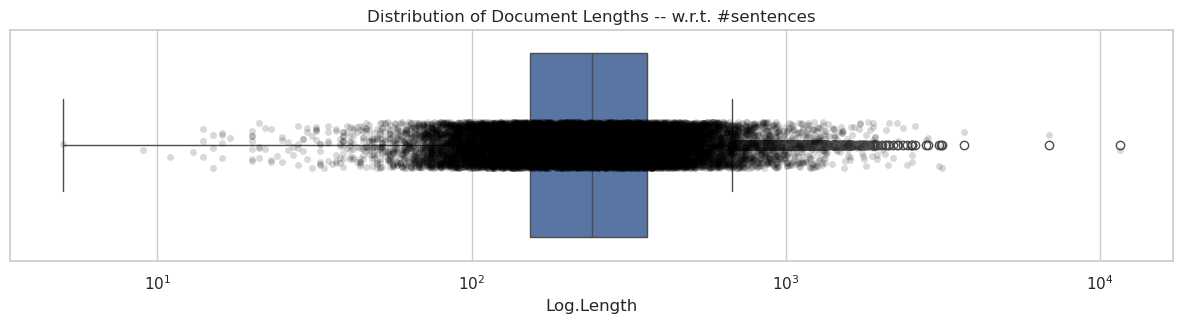

In [5]:
plt.figure(figsize=(15, 3))
sns.set_theme(style="whitegrid")
sns.boxplot(data=sent_lengths, orient='h')
sns.stripplot(data=sent_lengths, marker="o", alpha=0.15, color="black", orient='h')
plt.title("Distribution of Document Lengths -- w.r.t. #sentences")
plt.xscale('log')
plt.xlabel("Log.Length")
plt.show()

In [6]:
print (np.mean(sent_lengths))
print (np.percentile(sent_lengths, 95))
print (np.percentile(sent_lengths, 97.5))
print (np.percentile(sent_lengths, 98.5))
print (np.percentile(sent_lengths, 99))

290.4081340807688
651.0
823.0
961.3549999999996
1121.3799999999974


In [4]:
new_max_len = 1000

##### Very Important for creating Vocab dictionary

In [6]:
"""loader_train, loader_val, loader_test, _ , _ , vocab_sent, invert_vocab_sent = create_loaders(df_train, df_test, new_max_len, 32, df_val=df_val, task="summarization")

#save sentence dictionary-vocabulary on disk
sent_dict = pd.DataFrame(data={'Sentence_id': list(invert_vocab_sent.keys()), 'Sentence': list(invert_vocab_sent.values())})
sent_dict.to_csv(in_path+"vocab_sentences.csv", index=False)
""" 

Train dictionary comprises 4712480 sentences.
Train+Val dictionary comprises 4979428 sentences.
Train+Val+Test dictionary comprises 5228614 sentences.


In [5]:
#create loader from existing sentence vocabulary
loader_train, loader_val, loader_test, _ , _ , _, _ = create_loaders(df_train, df_test, 1000, 32, df_val=df_val, 
                                                                     task="summarization", tokenizer_from_scratch=False, path_ckpt=in_path)

##### Comparison of Trained Models 

In [6]:
batch_size = 32
num_classes = 2
std = 0.5
num_print = 5
granularity= "local"

In [7]:
path_models = "/scratch/mbugueno/HomoGraphs_GovReports/"
df_logger = pd.read_csv(path_models+"df_logger_cw.csv")
df_logger.sort_values(by="Score", ascending=False, inplace=True)
df_logger


,Model,Path,Score,Test score,Setting,Stop epoch,Temperature,Training_time,Total_time
31,Extended_Anneal,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.506591,0.501256,config/Summarizer/multi_summarizer_anneal.yaml,11,0.216276,38797.850838,38988.875199
33,Extended_Anneal,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.494296,0.488457,config/Summarizer/multi_summarizer_anneal.yaml,16,0.100000,57269.525905,57453.041142
26,Extended_Sigmoid,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.481313,0.483012,config/Summarizer/multi_summarizer_sigmoid.yaml,18,1.000000,59894.896585,60072.994874
32,Extended_Anneal,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.480622,0.481314,config/Summarizer/multi_summarizer_anneal.yaml,12,0.173774,47200.350262,47396.610425
30,Extended_Anneal,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.476978,0.477321,config/Summarizer/multi_summarizer_anneal.yaml,13,0.139624,44526.219740,44707.141817
29,Extended_Sigmoid,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.469632,0.471594,config/Summarizer/multi_summarizer_sigmoid.yaml,17,1.000000,58931.268334,59115.511090
28,Extended_Sigmoid,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.463394,0.459358,config/Summarizer/multi_summarizer_sigmoid.yaml,18,1.000000,61272.033330,61454.739352
9,Extended_ReLu,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.462483,0.464990,config/Summarizer/ext_summarizer_relu.yaml,16,1.000000,72192.191147,72431.674665
34,Extended_Anneal,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.462401,0.451615,config/Summarizer/multi_summarizer_anneal.yaml,11,0.216276,39362.720620,39548.082395
18,Extended_Step,/scratch/mbugueno/HomoGraphs_GovReports/Extend...,0.460039,0.463360,config/Summarizer/ext_summarizer_step.yaml,19,0.100000,72208.139769,72424.939010


In [8]:
def calculate_avg_dev_results_summarizer(model_name, df_logger, multi=False): ##val and test
    #avg_acc_train = []
    avg_acc_val = []
    avg_acc_test = []
    #avg_f1_train = []
    avg_f1_val = []
    avg_f1_test = []
    matched = False 

    for register in df_logger.iterrows():
        if multi:
            if register[1]["Model"]==model_name and "multi" in register[1]["Setting"]:
                path_checkpoint, model_score = register[1]["Path"], register[1]["Score"]
                matched = True
            else:
                continue            
        else:
            if register[1]["Model"]==model_name and "multi" not in register[1]["Setting"]:
                path_checkpoint, model_score = register[1]["Path"], register[1]["Score"]
                matched = True
            else:    
                continue

        if matched:    
            loader_train, loader_val, loader_test, _ , _ , _, _ = create_loaders(df_train, df_test, 1000, 32, df_val=df_val, task="summarization", tokenizer_from_scratch=False, path_ckpt=in_path)
            
            print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
            if multi:
                model_lightning = MHASummarizer_extended.load_from_checkpoint(path_checkpoint)
            else: 
                model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)

            #preds_t, _, all_labels_t, _, _ = model_lightning.predict(loader_train, cpu_store=False)
            preds_v, _, all_labels_v, _, _ = model_lightning.predict(loader_val, cpu_store=False)
            preds_test, _, all_labels_test, _, _ = model_lightning.predict(loader_test, cpu_store=False)

            #acc_train, f1_all_train = eval_results(preds_t, all_labels_t, num_classes, "Train", print_results=False)
            acc_val, f1_all_val = eval_results(preds_v, all_labels_v, num_classes, "Val", print_results=False)
            acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test", print_results=False) 
            #avg_acc_train.append(acc_train)
            #avg_f1_train.append(f1_all_train)
            avg_acc_val.append(acc_val)   
            avg_f1_val.append(f1_all_val)
            avg_acc_test.append(acc_test)   
            avg_f1_test.append(f1_all_test) 
            matched = False
    
    #avg_acc_train = torch.tensor(avg_acc_train)
    avg_acc_val = torch.tensor(avg_acc_val)
    avg_acc_test = torch.tensor(avg_acc_test)
    #print ("[Train] Avg. Acc:", avg_acc_train.mean().item(), "+-", avg_acc_train.std().item())
    print ("[Val] Avg. Acc:", avg_acc_val.mean().item(), "+-", avg_acc_val.std().item(), "--- Avg. F1-score:", torch.stack(avg_f1_val, dim=0).mean(dim=0).numpy(), "+-", torch.stack(avg_f1_val, dim=0).std(dim=0).numpy())
    print ("[Test] Avg. Acc:", avg_acc_test.mean().item(), "+-", avg_acc_test.std().item(), "--- Avg. F1-score:", torch.stack(avg_f1_test, dim=0).mean(dim=0).numpy(), "+-", torch.stack(avg_f1_test, dim=0).std(dim=0).numpy())
    #print ("[Train] Avg. F1-score:", torch.stack(avg_f1_train, dim=0).mean(dim=0).numpy(), "+-", torch.stack(avg_f1_train, dim=0).std(dim=0).numpy())
    
    return

In [9]:
calculate_avg_dev_results_summarizer("Extended_Anneal", df_logger)
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_Anneal").dropna()


Loading Extended_Anneal (0.456 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=05-Val_f1-ma=0.46.ckpt

Loading Extended_Anneal (0.455 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=06-Val_f1-ma=0.46.ckpt

Loading Extended_Anneal (0.450 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=05-Val_f1-ma=0.45.ckpt

Loading Extended_Anneal (0.416 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=03-Val_f1-ma=0.42.ckpt

Loading Extended_Anneal (0.395 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=00-Val_f1-ma=0.40.ckpt
[Val] Avg. Acc: 0.5686780214309692 +- 0.04884287342429161 --- Avg. F1-score: [0.7084637  0.16268066] +- [0.04339847 0.0128421 ]
[Test] Avg. Acc: 0.5572301745414734 +- 0.049534108489751816 --- Avg. F1-score: [0.6962181  0.17524092] +- [0.04520749 0.01225994]


,Model,Score,Test score
6,Extended_Anneal,0.456467,0.461932
1,Extended_Anneal,0.455290,0.454607
13,Extended_Anneal,0.449767,0.451254
8,Extended_Anneal,0.415695,0.413475
3,Extended_Anneal,0.395462,0.397380


In [9]:
calculate_avg_dev_results_summarizer("Extended_Anneal", df_logger, multi=True)
tempo= df_logger[['Model', 'Score', 'Test score', 'Setting']].where(df_logger['Model']=="Extended_Anneal").dropna()
tempo.where(tempo['Setting']=="config/Summarizer/multi_summarizer_anneal.yaml").dropna()


Loading Extended_Anneal (0.507 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=06-Val_f1-ma=0.51.ckpt

Loading Extended_Anneal (0.494 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=11-Val_f1-ma=0.49.ckpt

Loading Extended_Anneal (0.481 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=07-Val_f1-ma=0.48.ckpt

Loading Extended_Anneal (0.477 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=08-Val_f1-ma=0.48.ckpt

Loading Extended_Anneal (0.462 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=06-Val_f1-ma=0.46-v1.ckpt
[Val] Avg. Acc: 0.6547558307647705 +- 0.030848585069179535 --- Avg. F1-score: [0.78042394 0.18742637] +- [0.0244007  0.00784378]
[Test] Avg. Acc: 0.6340631246566772 +- 0.03454693406820297 --- Avg. F1-score: [0.7624661  0.19751899] +- [0.02875322 0.00803565]


,Model,Score,Test score,Setting
31,Extended_Anneal,0.506591,0.501256,config/Summarizer/multi_summarizer_anneal.yaml
33,Extended_Anneal,0.494296,0.488457,config/Summarizer/multi_summarizer_anneal.yaml
32,Extended_Anneal,0.480622,0.481314,config/Summarizer/multi_summarizer_anneal.yaml
30,Extended_Anneal,0.476978,0.477321,config/Summarizer/multi_summarizer_anneal.yaml
34,Extended_Anneal,0.462401,0.451615,config/Summarizer/multi_summarizer_anneal.yaml


In [8]:
calculate_avg_dev_results_summarizer("Extended_ReLu", df_logger)
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_ReLu").dropna()


Loading Extended_ReLu (0.462 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_ReLu/Extended_ReLu-epoch=11-Val_f1-ma=0.46.ckpt

Loading Extended_ReLu (0.434 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_ReLu/Extended_ReLu-epoch=02-Val_f1-ma=0.43.ckpt

Loading Extended_ReLu (0.421 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_ReLu/Extended_ReLu-epoch=03-Val_f1-ma=0.42.ckpt

Loading Extended_ReLu (0.410 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_ReLu/Extended_ReLu-epoch=03-Val_f1-ma=0.41.ckpt

Loading Extended_ReLu (0.408 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_ReLu/Extended_ReLu-epoch=08-Val_f1-ma=0.41.ckpt
[Val] Avg. Acc: 0.5518444776535034 +- 0.04074864834547043 --- Avg. F1-score: [0.6931858  0.16297439] +- [0.03658668 0.01102979]
[Test] Avg. Acc: 0.5475714802742004 +- 0.04006943106651306 --- Avg. F1-score: [0.6873178  0.17605023] +- [0.03694095 0.00883165]


,Model,Score,Test score
9,Extended_ReLu,0.462483,0.464990
4,Extended_ReLu,0.434369,0.440017
16,Extended_ReLu,0.420744,0.427542
12,Extended_ReLu,0.410463,0.413552
2,Extended_ReLu,0.408179,0.412319


In [9]:
calculate_avg_dev_results_summarizer("Extended_Sigmoid", df_logger)
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_Sigmoid").dropna()


Loading Extended_Sigmoid (0.445 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=11-Val_f1-ma=0.45.ckpt

Loading Extended_Sigmoid (0.444 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=03-Val_f1-ma=0.44.ckpt

Loading Extended_Sigmoid (0.423 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=08-Val_f1-ma=0.42.ckpt

Loading Extended_Sigmoid (0.420 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=04-Val_f1-ma=0.42.ckpt

Loading Extended_Sigmoid (0.396 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=03-Val_f1-ma=0.40.ckpt
[Val] Avg. Acc: 0.5475273132324219 +- 0.036975178867578506 --- Avg. F1-score: [0.688833   0.16604124] +- [0.03422531 0.00732324]
[Test] Avg. Acc: 0.5422421097755432 +- 0.032371826469898224 --- Avg. F1-score: [0.6822496  0.17796296] +- [0.03039543 0.00665088]


,Model,Score,Test score
5,Extended_Sigmoid,0.445418,0.449443
10,Extended_Sigmoid,0.443802,0.443469
7,Extended_Sigmoid,0.423463,0.432796
0,Extended_Sigmoid,0.419971,0.420413
15,Extended_Sigmoid,0.396248,0.404411


In [20]:
calculate_avg_dev_results_summarizer("Extended_Sigmoid", df_logger, multi=True)
tempo= df_logger[['Model', 'Score', 'Test score', 'Setting']].where(df_logger['Model']=="Extended_Sigmoid").dropna()
tempo.where(tempo['Setting']=="config/Summarizer/multi_summarizer_sigmoid.yaml").dropna()


Loading Extended_Sigmoid (0.481 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=13-Val_f1-ma=0.48.ckpt

Loading Extended_Sigmoid (0.470 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=12-Val_f1-ma=0.47.ckpt

Loading Extended_Sigmoid (0.463 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=13-Val_f1-ma=0.46.ckpt

Loading Extended_Sigmoid (0.450 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=11-Val_f1-ma=0.45-v1.ckpt

Loading Extended_Sigmoid (0.435 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=01-Val_f1-ma=0.44.ckpt
[Val] Avg. Acc: 0.6084524393081665 +- 0.0301089808344841 --- Avg. F1-score: [0.7423295  0.18173239] +- [0.02477689 0.01403503]
[Test] Avg. Acc: 0.5895328521728516 +- 0.033606674522161484 --- Avg. F1-score: [0.72452486 0.19130492] +- [0.02862791 0.01396969]


,Model,Score,Test score,Setting
26,Extended_Sigmoid,0.481313,0.483012,config/Summarizer/multi_summarizer_sigmoid.yaml
29,Extended_Sigmoid,0.469632,0.471594,config/Summarizer/multi_summarizer_sigmoid.yaml
28,Extended_Sigmoid,0.463394,0.459358,config/Summarizer/multi_summarizer_sigmoid.yaml
25,Extended_Sigmoid,0.450400,0.445132,config/Summarizer/multi_summarizer_sigmoid.yaml
27,Extended_Sigmoid,0.435068,0.430478,config/Summarizer/multi_summarizer_sigmoid.yaml


In [12]:
calculate_avg_dev_results_summarizer("Extended_Step", df_logger) ##### still running
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_Step").dropna()


Loading Extended_Step (0.460 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Step/Extended_Step-epoch=14-Val_f1-ma=0.46.ckpt

Loading Extended_Step (0.460 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Step/Extended_Step-epoch=19-Val_f1-ma=0.46.ckpt

Loading Extended_Step (0.437 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Step/Extended_Step-epoch=11-Val_f1-ma=0.44.ckpt

Loading Extended_Step (0.428 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Step/Extended_Step-epoch=07-Val_f1-ma=0.43.ckpt

Loading Extended_Step (0.411 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Step/Extended_Step-epoch=05-Val_f1-ma=0.41.ckpt
[Val] Avg. Acc: 0.5610589385032654 +- 0.0668441653251648 --- Avg. F1-score: [0.69987    0.16495433] +- [0.06301724 0.00845626]
[Test] Avg. Acc: 0.5585999488830566 +- 0.06663315743207932 --- Avg. F1-score: [0.6958319  0.17797388] +- [0.06398422 0.00908344]


,Model,Score,Test score
18,Extended_Step,0.460039,0.463360
24,Extended_Step,0.459906,0.464749
22,Extended_Step,0.437417,0.444245
20,Extended_Step,0.428369,0.436882
11,Extended_Step,0.411117,0.375278


In [10]:
calculate_avg_dev_results_summarizer("Extended_NoTemp", df_logger) ##### still running
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_NoTemp").dropna()


Loading Extended_NoTemp (0.450 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_NoTemp/Extended_NoTemp-epoch=03-Val_f1-ma=0.45.ckpt

Loading Extended_NoTemp (0.436 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_NoTemp/Extended_NoTemp-epoch=08-Val_f1-ma=0.44.ckpt

Loading Extended_NoTemp (0.428 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_NoTemp/Extended_NoTemp-epoch=15-Val_f1-ma=0.43.ckpt

Loading Extended_NoTemp (0.412 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_NoTemp/Extended_NoTemp-epoch=10-Val_f1-ma=0.41.ckpt

Loading Extended_NoTemp (0.397 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_NoTemp/Extended_NoTemp-epoch=05-Val_f1-ma=0.40.ckpt
[Val] Avg. Acc: 0.5463657975196838 +- 0.03900620713829994 --- Avg. F1-score: [0.68777734 0.16466333] +- [0.03629914 0.00578729]
[Test] Avg. Acc: 0.5390735864639282 +- 0.041198063641786575 --- Avg. F1-score: [0.678767   0.17789707] +- [0.03911666 0.00606932]


,Model,Score,Test score
21,Extended_NoTemp,0.449609,0.452469
14,Extended_NoTemp,0.435811,0.444436
23,Extended_NoTemp,0.428121,0.430738
17,Extended_NoTemp,0.412460,0.414005
19,Extended_NoTemp,0.396620,0.400013


#### Best by model

In [13]:
loader_train, loader_val, loader_test, _ , _ , _, _ = create_loaders(df_train, df_test, 1000, 32, df_val=df_val, task="summarization", tokenizer_from_scratch=False, path_ckpt=in_path)
            

In [9]:
model_name= "Extended_Anneal"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Anneal (0.456 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=05-Val_f1-ma=0.46.ckpt
Model temperature 0.2691732647098334

Trained Model Results on partition: Val
Val Acc: tensor(0.6077)
Val F1-score macro: tensor(0.4580)
Val F1-score for each class: tensor([0.7429, 0.1732])

Trained Model Results on partition: Test
Test Acc: tensor(0.6042)
Test F1-score macro: tensor(0.4619)
Test F1-score for each class: tensor([0.7386, 0.1852])


In [10]:
### 2-Layer MHA -- Sigmoid
model_name= "Extended_Anneal"
num_classes = 2
setting_file= "config/Summarizer/multi_summarizer_anneal.yaml"
tempo= df_logger.where(df_logger['Setting']==setting_file).dropna()
path_checkpoint, model_score = retrieve_parameters(model_name, tempo)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer_extended.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Anneal (0.507 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=06-Val_f1-ma=0.51.ckpt
Model temperature 0.2162759803585647

Trained Model Results on partition: Val
Val Acc: tensor(0.6941)
Val F1-score macro: tensor(0.5055)
Val F1-score for each class: tensor([0.8109, 0.2001])

Trained Model Results on partition: Test
Test Acc: tensor(0.6730)
Test F1-score macro: tensor(0.5013)
Test F1-score for each class: tensor([0.7939, 0.2086])


In [10]:
model_name= "Extended_ReLu"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_ReLu (0.462 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_ReLu/Extended_ReLu-epoch=11-Val_f1-ma=0.46.ckpt
Model temperature 1

Trained Model Results on partition: Val
Val Acc: tensor(0.6132)
Val F1-score macro: tensor(0.4643)
Val F1-score for each class: tensor([0.7468, 0.1818])

Trained Model Results on partition: Test
Test Acc: tensor(0.6050)
Test F1-score macro: tensor(0.4650)
Test F1-score for each class: tensor([0.7387, 0.1913])


In [11]:
model_name= "Extended_Sigmoid"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Sigmoid (0.445 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=11-Val_f1-ma=0.45.ckpt
Model temperature 1

Trained Model Results on partition: Val
Val Acc: tensor(0.5832)
Val F1-score macro: tensor(0.4481)
Val F1-score for each class: tensor([0.7212, 0.1750])

Trained Model Results on partition: Test
Test Acc: tensor(0.5757)
Test F1-score macro: tensor(0.4494)
Test F1-score for each class: tensor([0.7131, 0.1858])


In [15]:
### 2-Layer MHA -- Sigmoid
model_name= "Extended_Sigmoid"
num_classes = 2
setting_file= "config/Summarizer/multi_summarizer_sigmoid.yaml"
tempo= df_logger.where(df_logger['Setting']==setting_file).dropna()
path_checkpoint, model_score = retrieve_parameters(model_name, tempo)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer_extended.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Sigmoid (0.481 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=13-Val_f1-ma=0.48.ckpt
Model temperature 1

Trained Model Results on partition: Val
Val Acc: tensor(0.6440)
Val F1-score macro: tensor(0.4826)
Val F1-score for each class: tensor([0.7716, 0.1936])

Trained Model Results on partition: Test
Test Acc: tensor(0.6322)
Test F1-score macro: tensor(0.4830)
Test F1-score for each class: tensor([0.7607, 0.2053])


In [12]:
model_name= "Extended_Step"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Step (0.460 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Step/Extended_Step-epoch=14-Val_f1-ma=0.46.ckpt
Model temperature 0.1

Trained Model Results on partition: Val
Val Acc: tensor(0.6143)
Val F1-score macro: tensor(0.4603)
Val F1-score for each class: tensor([0.7486, 0.1721])

Trained Model Results on partition: Test
Test Acc: tensor(0.6084)
Test F1-score macro: tensor(0.4634)
Test F1-score for each class: tensor([0.7424, 0.1844])


In [13]:
model_name= "Extended_NoTemp"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_NoTemp (0.450 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_NoTemp/Extended_NoTemp-epoch=03-Val_f1-ma=0.45.ckpt
Model temperature 1



Trained Model Results on partition: Val
Val Acc: tensor(0.5980)
Val F1-score macro: tensor(0.4491)
Val F1-score for each class: tensor([0.7355, 0.1628])

Trained Model Results on partition: Test
Test Acc: tensor(0.5915)
Test F1-score macro: tensor(0.4525)
Test F1-score for each class: tensor([0.7284, 0.1765])


#### Escoger el/los mejores settings y crear filenames para dichos folder + graph objects

In [ ]:
###check que predice roule L malo

##### Annealing 


Loading Extended_Anneal (0.456 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=05-Val_f1-ma=0.46.ckpt


Model temperature 0.2691732647098334

Trained Model Results on partition: Val
Val Acc: tensor(0.6077)
Val F1-score macro: tensor(0.4580)
Val F1-score for each class: tensor([0.7429, 0.1732])

Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  0 -- #Sentences:  67
Source text:
 ['Part of the Mariana Islands Archipelago, the CNMI is a chain of 14 islands in the western Pacific Ocean, just north of Guam and about 3,200 miles west of Hawaii.', 'The CNMI has a total population of 53,890, according to the CNMI’s 2016 Household, Income, and Expenditures Survey.', 'Almost 90 percent of the population (48,200) resided on the island of Saipan, with an additional 6 percent (3,056) on the island of Tinian and 5 percent (2,635) on the island of Rota.', 'The Consolidated Natural Resources Act of 2008 amended the U.S.– CNMI covenant to apply federal immigration law to the CNMI after a transition period.', 'To provide for an orderly transition from the CNMI immigration syst

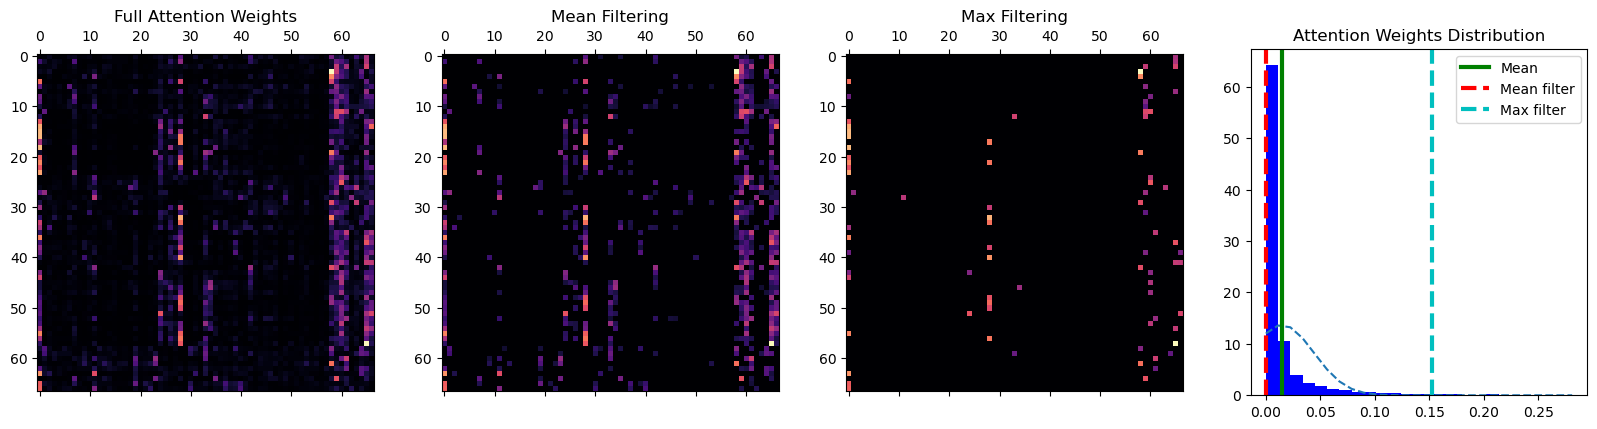


Document ID:  1 -- #Sentences:  148
Source text:
 ['The U.S. pipeline network includes both interstate and intrastate pipelines, the vast majority of which fall into the latter category: Interstate pipelines: Interstate pipelines are primarily large-volume transmission pipelines that carry gas or hazardous liquid–sometimes over hundreds of miles—to communities and large-volume users (e.g., factories).', 'At the start of 2017, there were about 340,000 miles of interstate transmission pipelines nationwide.', 'Newly tapped domestic gas and oil deposits have resulted in an increase in the existing pipeline infrastructure to transport natural gas and oil.', 'Intrastate pipelines: Intrastate pipelines are primarily composed of gas distribution and some transmission pipelines that transport natural gas pipelines to residential, commercial, and industrial customers.', 'As of 2015, there were about 2.2 million miles of distribution pipelines nationwide.', 'In addition, an estimated 18,000 mile

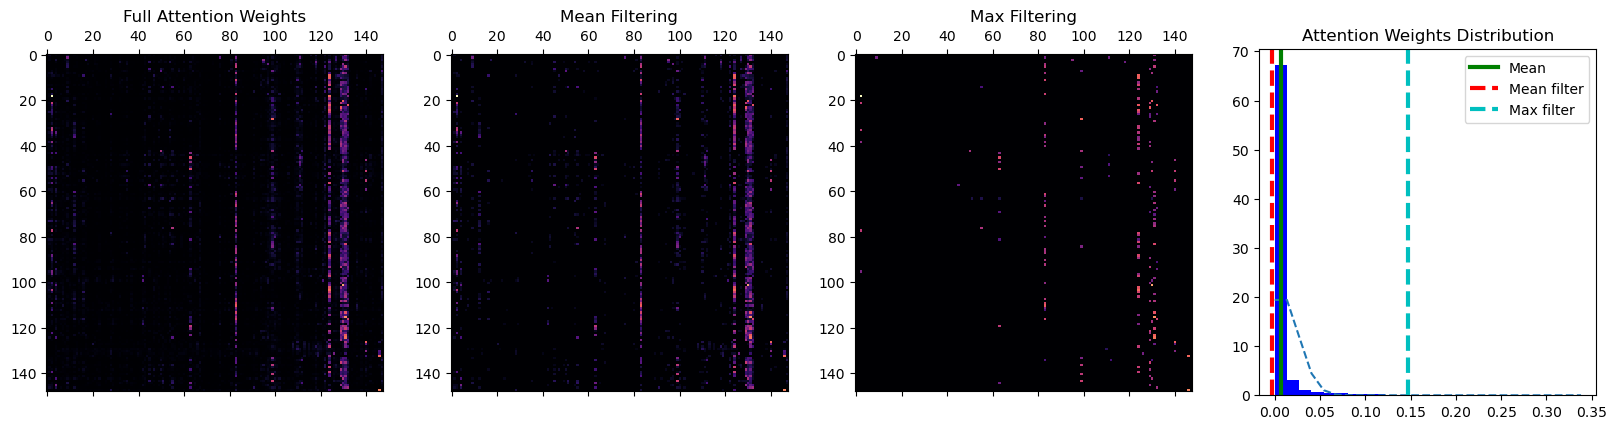


Document ID:  2 -- #Sentences:  137
Source text:
 ['VA’s mission is to promote the health, welfare, and dignity of all veterans in recognition of their service to the nation by ensuring that they receive medical care, benefits, social support, and lasting memorials.', 'In carrying out this mission, the department operates one of the largest health care delivery systems in the United States, providing health care services to approximately 9 million veterans throughout the United States, Philippines, Virgin Islands, Puerto Rico, American Samoa, and Guam.', 'In 2015, we designated VA health care as a high-risk area for the federal government, and we continue to be concerned about the department’s ability to ensure that its resources are being used cost-effectively and efficiently to improve veterans’ timely access to health care.', 'In part, we identified limitations in the capacity of VA’s existing IT systems, including the outdated, inefficient nature of certain systems and a lack of s

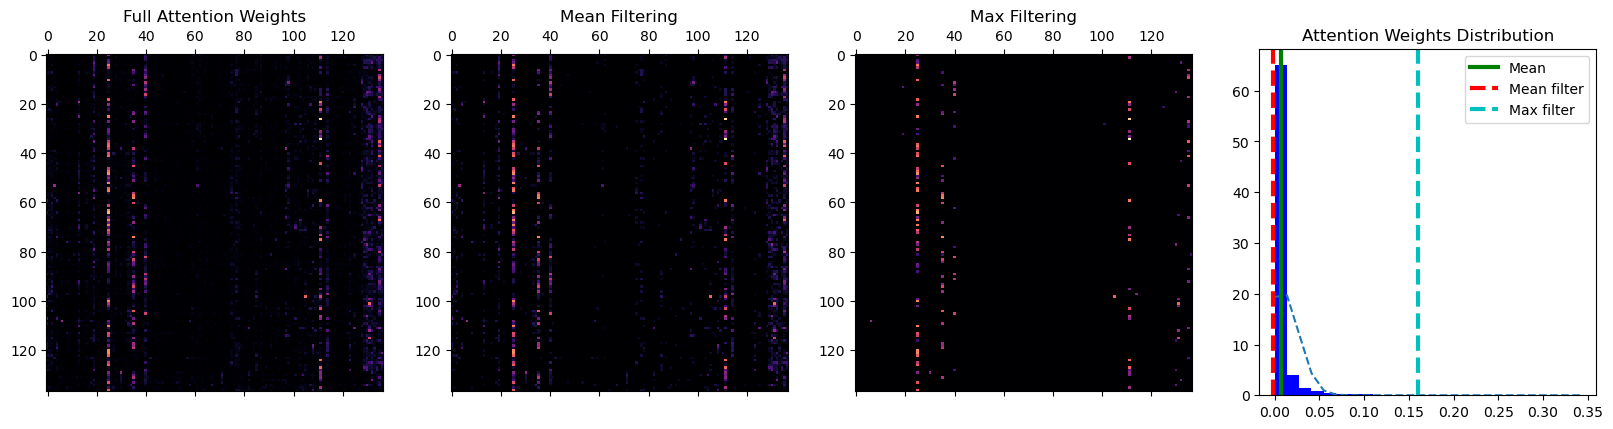


Document ID:  3 -- #Sentences:  187
Source text:
 ['JWST is envisioned to be a large deployable space telescope, optimized for infrared observations, and the scientific successor to the aging Hubble Space Telescope.', 'JWST is being designed for a 5-year mission to find the first stars, study planets in other solar systems to search for the building blocks of life elsewhere in the universe, and trace the evolution of galaxies from their beginning to their current formation.', 'JWST is intended to operate in an orbit approximately 1.5 million kilometers—or 1 million miles—from the Earth.', 'With a 6.5-meter primary mirror, JWST is expected to operate at about 100 times the sensitivity of the Hubble Space Telescope.', 'JWST’s science instruments are designed to observe very faint infrared sources and therefore are required to operate at extremely cold temperatures.', 'To help keep these instruments cold, a multi-layered tennis court-sized sunshield is being developed to protect the mirr

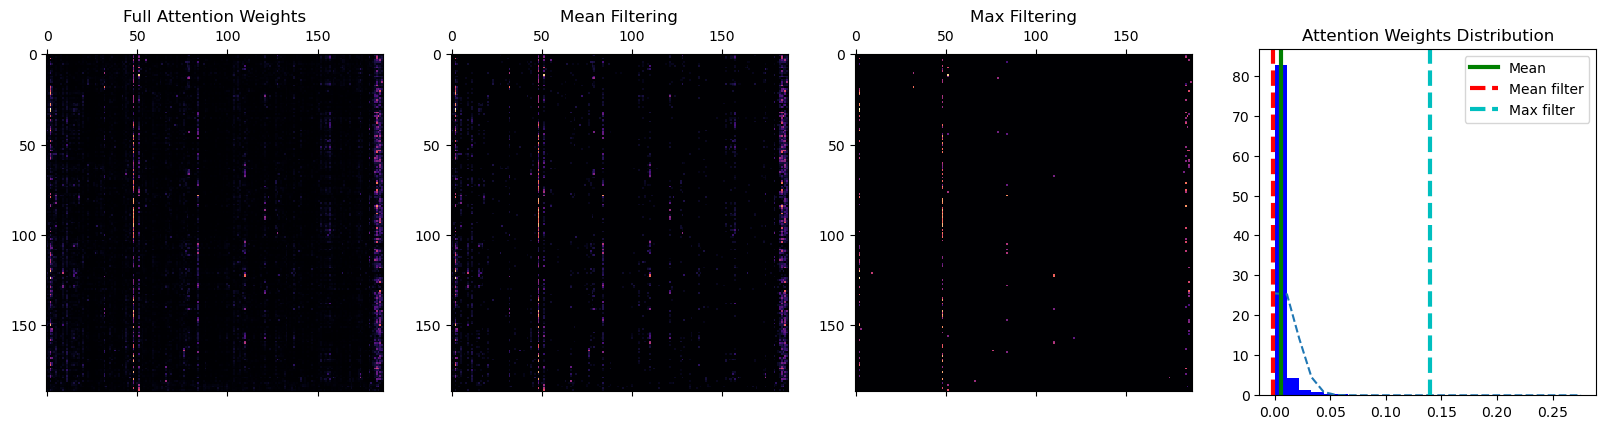


Document ID:  4 -- #Sentences:  230
Source text:
 ['As we have previously reported, 911 services have evolved from basic 911—which provided Americans with a universally recognized emergency number—to Enhanced 911 which also routes calls to the appropriate call center and provides information about the caller’s location and a call back number.', 'NG911 represents the next evolution in 911 services by using IP-based technology to deliver and process 911 traffic.', 'Under NG911, call centers will continue to receive voice calls and location information, but will also be able to accommodate emergency communications from the range of technologies in use today.', 'In addition, NG911 systems provide call centers with enhanced capabilities to route and transfer calls and data, which could improve call centers’ abilities to handle overflow calls and increase information sharing with first responders.', 'Generally speaking, 911 communications begin when a caller dials 911 using a landline, wire

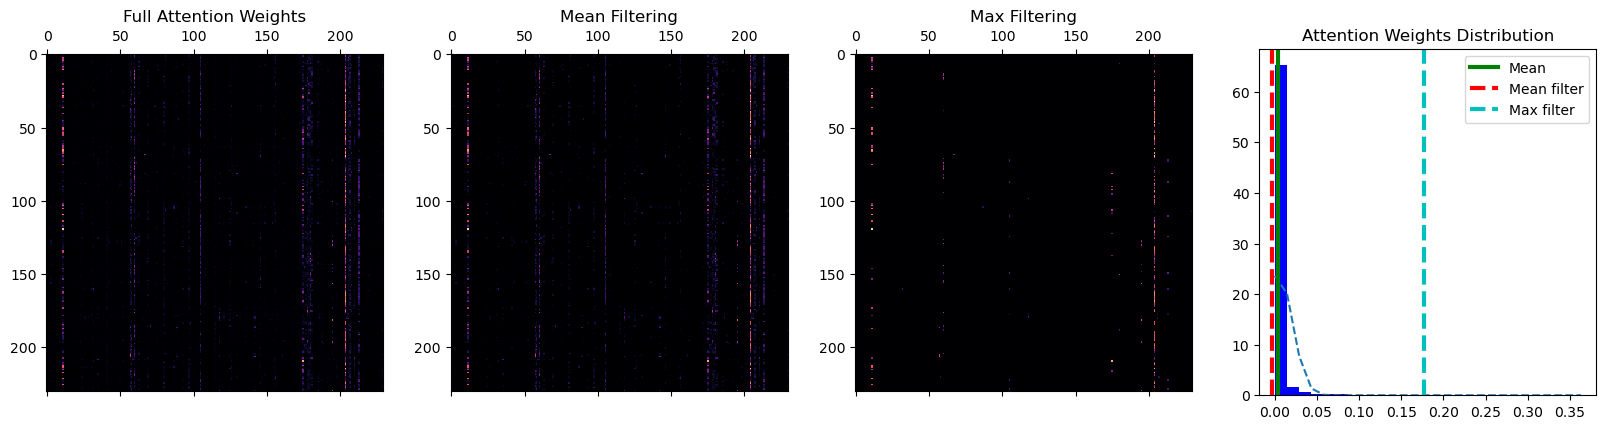

Done.


In [8]:
filtering=True
num_print= 5
tolerance = 0.5
granularity= "local" 
model_name= "Extended_Anneal"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")

# Validation
filter = "mean"
filtered_matrices_v, total_nodes_v, total_edges_v, deletions_v = filtering_matrices(full_attn_weights_v, all_article_identifiers_v, df_val, print_samples=num_print,
                                                                                    degree_std=tolerance, with_filtering=filtering, filtering_type="mean", granularity=granularity)



#### Checking matrices from 2-layer Anneal 

In [8]:
filtering=True
num_print= 5
tolerance = 0.5
granularity= "local"
model_name= "Extended_Anneal"
num_classes = 2
setting_file= "config/Summarizer/multi_summarizer_anneal.yaml"
tempo= df_logger.where(df_logger['Setting']==setting_file).dropna()

path_checkpoint, model_score = retrieve_parameters(model_name, tempo)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer_extended.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")


Loading Extended_Anneal (0.507 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=06-Val_f1-ma=0.51.ckpt
Model temperature 0.2162759803585647

Trained Model Results on partition: Val
Val Acc: tensor(0.6941)
Val F1-score macro: tensor(0.5055)
Val F1-score for each class: tensor([0.8109, 0.2001])


In [20]:
labels_all = df_val['Calculated_Labels']
list_valid_sents = [len(clean_tokenization_sent(labels_sample, "label")) for labels_sample in labels_all]


Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  0 -- #Sentences:  67
Source text:
 ['Part of the Mariana Islands Archipelago, the CNMI is a chain of 14 islands in the western Pacific Ocean, just north of Guam and about 3,200 miles west of Hawaii.', 'The CNMI has a total population of 53,890, according to the CNMI’s 2016 Household, Income, and Expenditures Survey.', 'Almost 90 percent of the population (48,200) resided on the island of Saipan, with an additional 6 percent (3,056) on the island of Tinian and 5 percent (2,635) on the island of Rota.', 'The Consolidated Natural Resources Act of 2008 amended the U.S.– CNMI covenant to apply federal immigration law to the CNMI after a transition period.', 'To provide for an orderly transition from the CNMI immigration system to the U.S. federal immigration system under the immigration laws of the United States, DHS established the CW program in 2011.', 'Under the program, foreign workers are able to obtain, th

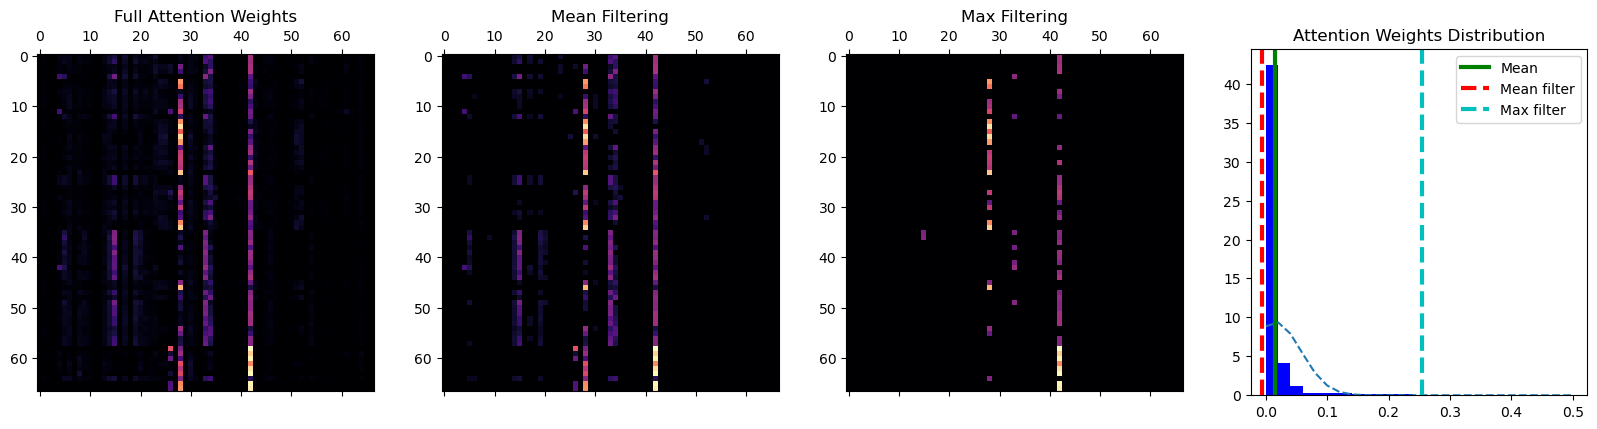


Document ID:  1 -- #Sentences:  148
Source text:
 ['The U.S. pipeline network includes both interstate and intrastate pipelines, the vast majority of which fall into the latter category: Interstate pipelines: Interstate pipelines are primarily large-volume transmission pipelines that carry gas or hazardous liquid–sometimes over hundreds of miles—to communities and large-volume users (e.g., factories).', 'At the start of 2017, there were about 340,000 miles of interstate transmission pipelines nationwide.', 'Newly tapped domestic gas and oil deposits have resulted in an increase in the existing pipeline infrastructure to transport natural gas and oil.', 'Intrastate pipelines: Intrastate pipelines are primarily composed of gas distribution and some transmission pipelines that transport natural gas pipelines to residential, commercial, and industrial customers.', 'As of 2015, there were about 2.2 million miles of distribution pipelines nationwide.', 'In addition, an estimated 18,000 mile

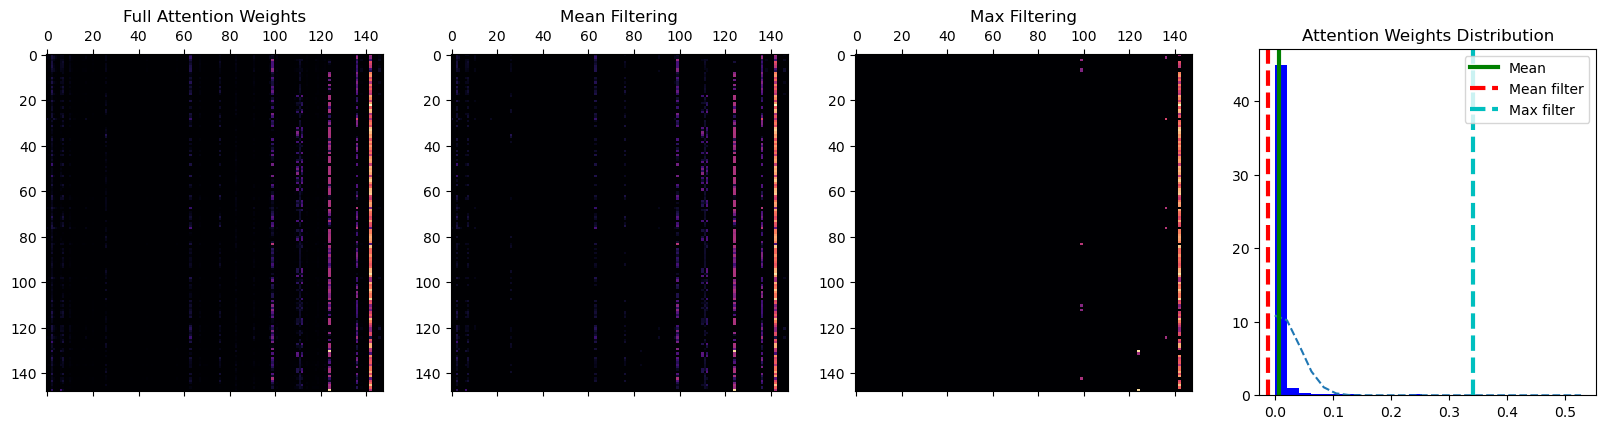


Document ID:  2 -- #Sentences:  137
Source text:
 ['VA’s mission is to promote the health, welfare, and dignity of all veterans in recognition of their service to the nation by ensuring that they receive medical care, benefits, social support, and lasting memorials.', 'In carrying out this mission, the department operates one of the largest health care delivery systems in the United States, providing health care services to approximately 9 million veterans throughout the United States, Philippines, Virgin Islands, Puerto Rico, American Samoa, and Guam.', 'In 2015, we designated VA health care as a high-risk area for the federal government, and we continue to be concerned about the department’s ability to ensure that its resources are being used cost-effectively and efficiently to improve veterans’ timely access to health care.', 'In part, we identified limitations in the capacity of VA’s existing IT systems, including the outdated, inefficient nature of certain systems and a lack of s

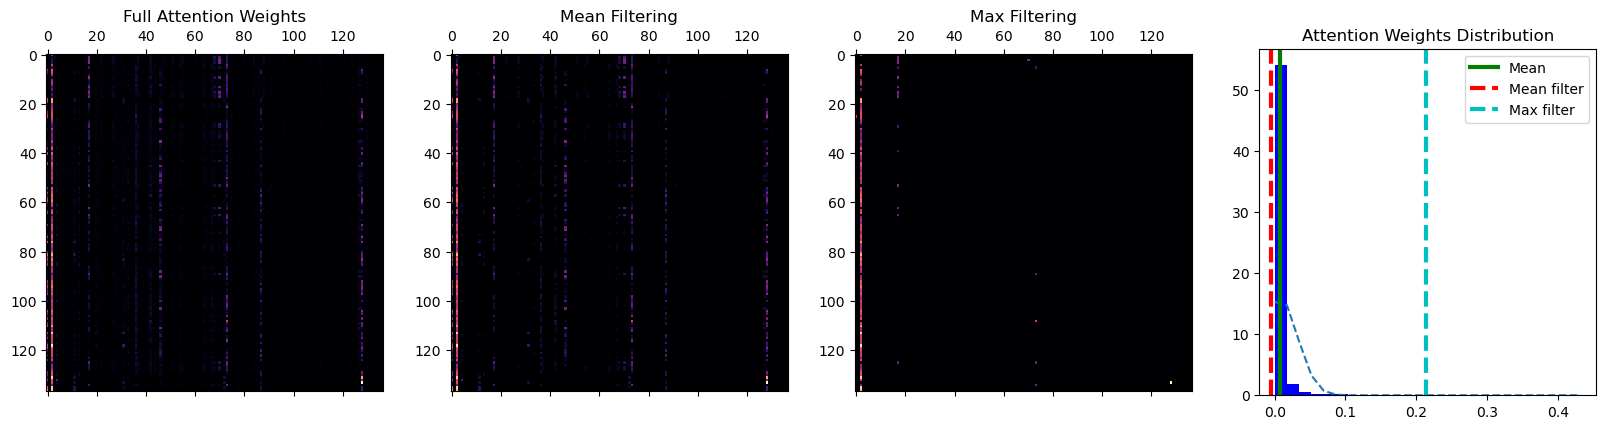


Document ID:  3 -- #Sentences:  187
Source text:
 ['JWST is envisioned to be a large deployable space telescope, optimized for infrared observations, and the scientific successor to the aging Hubble Space Telescope.', 'JWST is being designed for a 5-year mission to find the first stars, study planets in other solar systems to search for the building blocks of life elsewhere in the universe, and trace the evolution of galaxies from their beginning to their current formation.', 'JWST is intended to operate in an orbit approximately 1.5 million kilometers—or 1 million miles—from the Earth.', 'With a 6.5-meter primary mirror, JWST is expected to operate at about 100 times the sensitivity of the Hubble Space Telescope.', 'JWST’s science instruments are designed to observe very faint infrared sources and therefore are required to operate at extremely cold temperatures.', 'To help keep these instruments cold, a multi-layered tennis court-sized sunshield is being developed to protect the mirr

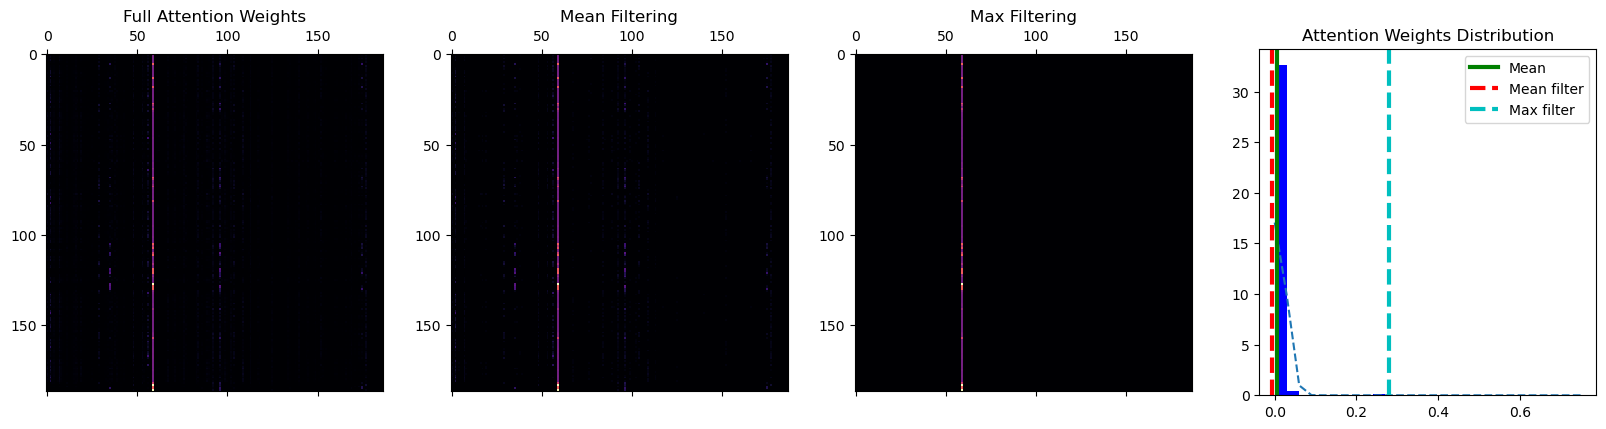


Document ID:  4 -- #Sentences:  230
Source text:
 ['As we have previously reported, 911 services have evolved from basic 911—which provided Americans with a universally recognized emergency number—to Enhanced 911 which also routes calls to the appropriate call center and provides information about the caller’s location and a call back number.', 'NG911 represents the next evolution in 911 services by using IP-based technology to deliver and process 911 traffic.', 'Under NG911, call centers will continue to receive voice calls and location information, but will also be able to accommodate emergency communications from the range of technologies in use today.', 'In addition, NG911 systems provide call centers with enhanced capabilities to route and transfer calls and data, which could improve call centers’ abilities to handle overflow calls and increase information sharing with first responders.', 'Generally speaking, 911 communications begin when a caller dials 911 using a landline, wire

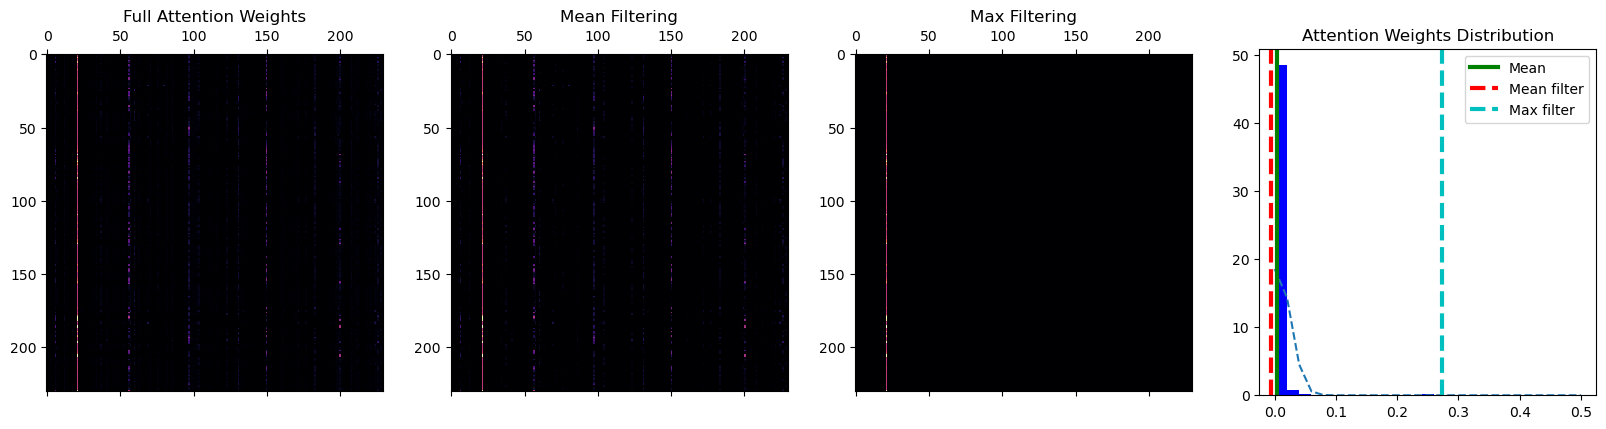

Done.


In [23]:
# Validation
filter = "mean"
filtered_matrices_v, total_nodes_v, total_edges_v, deletions_v = filtering_matrices(full_attn_weights_v, all_article_identifiers_v, list_valid_sents, df_val, print_samples=num_print,
                                                                                    degree_std=tolerance, with_filtering=filtering, filtering_type=filter, granularity=granularity)


##### Sigmoid Matrices

In [23]:
filtering=True
num_print= 5
tolerance = 0.5
granularity= "local"
model_name= "Extended_Sigmoid"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
#preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")
#acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Sigmoid (0.445 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Sigmoid/Extended_Sigmoid-epoch=11-Val_f1-ma=0.45.ckpt


Model temperature 1

Trained Model Results on partition: Val
Val Acc: tensor(0.5832)
Val F1-score macro: tensor(0.4481)
Val F1-score for each class: tensor([0.7212, 0.1750])



Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  0 -- #Sentences:  67
Source text:
 ['Part of the Mariana Islands Archipelago, the CNMI is a chain of 14 islands in the western Pacific Ocean, just north of Guam and about 3,200 miles west of Hawaii.', 'The CNMI has a total population of 53,890, according to the CNMI’s 2016 Household, Income, and Expenditures Survey.', 'Almost 90 percent of the population (48,200) resided on the island of Saipan, with an additional 6 percent (3,056) on the island of Tinian and 5 percent (2,635) on the island of Rota.', 'The Consolidated Natural Resources Act of 2008 amended the U.S.– CNMI covenant to apply federal immigration law to the CNMI after a transition period.', 'To provide for an orderly transition from the CNMI immigration system to the U.S. federal immigration system under the immigration laws of the United States, DHS established the CW program in 2011.', 'Under the program, foreign workers are able to obtain, th

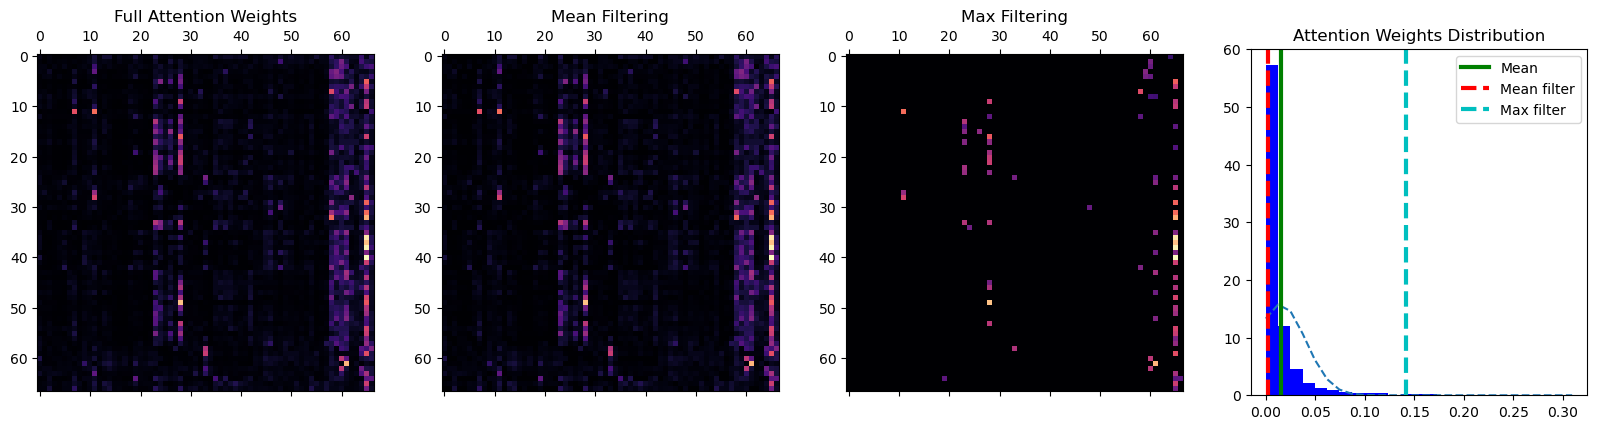


Document ID:  1 -- #Sentences:  148
Source text:
 ['The U.S. pipeline network includes both interstate and intrastate pipelines, the vast majority of which fall into the latter category: Interstate pipelines: Interstate pipelines are primarily large-volume transmission pipelines that carry gas or hazardous liquid–sometimes over hundreds of miles—to communities and large-volume users (e.g., factories).', 'At the start of 2017, there were about 340,000 miles of interstate transmission pipelines nationwide.', 'Newly tapped domestic gas and oil deposits have resulted in an increase in the existing pipeline infrastructure to transport natural gas and oil.', 'Intrastate pipelines: Intrastate pipelines are primarily composed of gas distribution and some transmission pipelines that transport natural gas pipelines to residential, commercial, and industrial customers.', 'As of 2015, there were about 2.2 million miles of distribution pipelines nationwide.', 'In addition, an estimated 18,000 mile

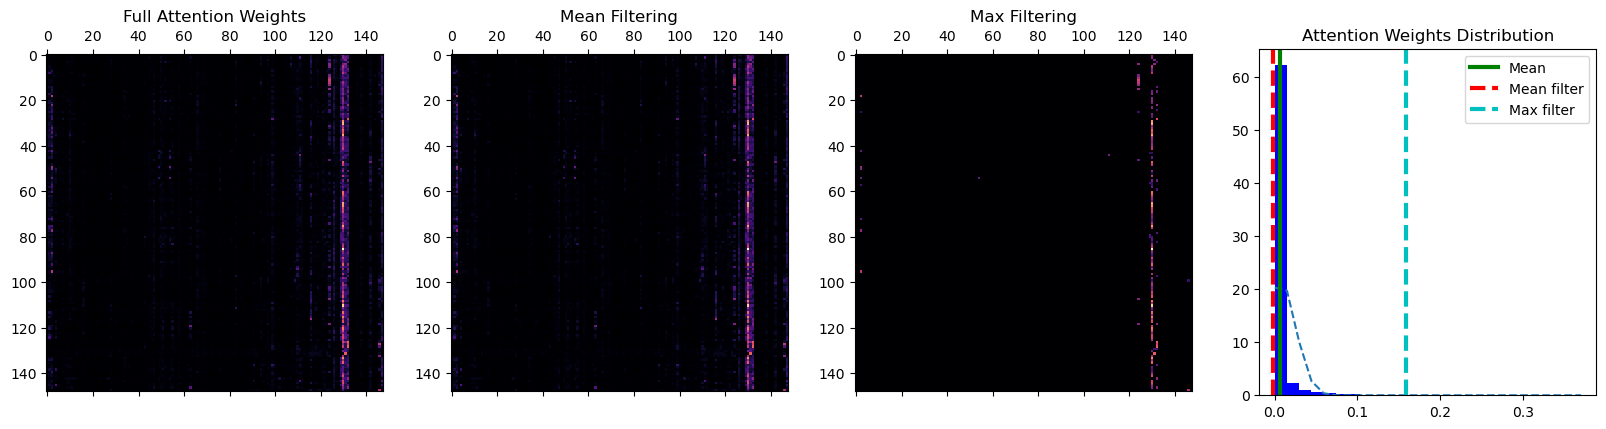


Document ID:  2 -- #Sentences:  137
Source text:
 ['VA’s mission is to promote the health, welfare, and dignity of all veterans in recognition of their service to the nation by ensuring that they receive medical care, benefits, social support, and lasting memorials.', 'In carrying out this mission, the department operates one of the largest health care delivery systems in the United States, providing health care services to approximately 9 million veterans throughout the United States, Philippines, Virgin Islands, Puerto Rico, American Samoa, and Guam.', 'In 2015, we designated VA health care as a high-risk area for the federal government, and we continue to be concerned about the department’s ability to ensure that its resources are being used cost-effectively and efficiently to improve veterans’ timely access to health care.', 'In part, we identified limitations in the capacity of VA’s existing IT systems, including the outdated, inefficient nature of certain systems and a lack of s

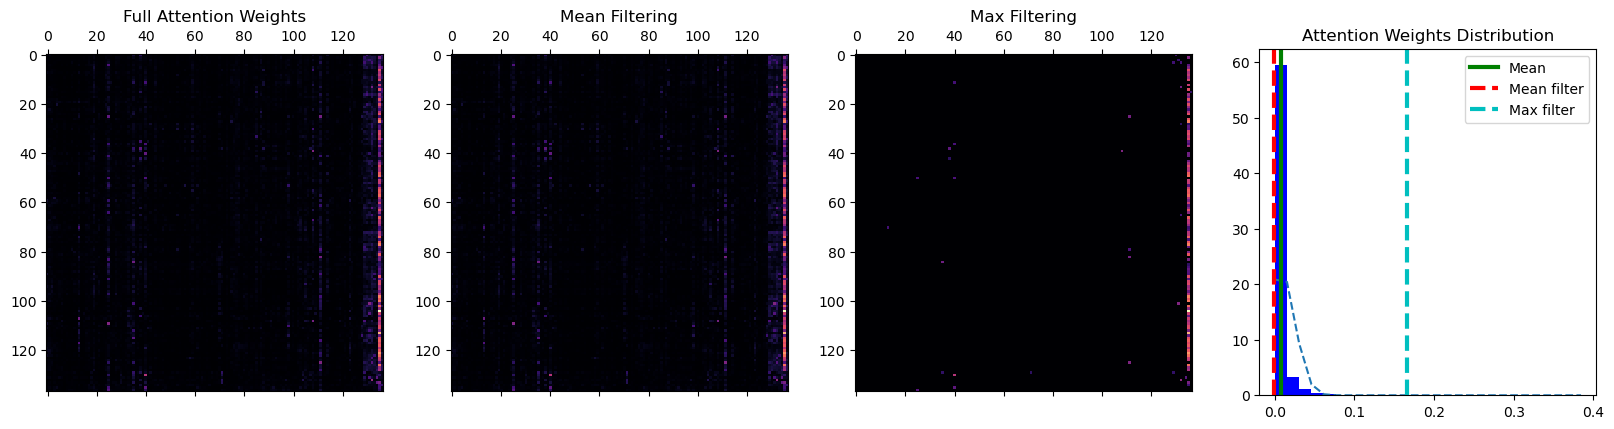


Document ID:  3 -- #Sentences:  187
Source text:
 ['JWST is envisioned to be a large deployable space telescope, optimized for infrared observations, and the scientific successor to the aging Hubble Space Telescope.', 'JWST is being designed for a 5-year mission to find the first stars, study planets in other solar systems to search for the building blocks of life elsewhere in the universe, and trace the evolution of galaxies from their beginning to their current formation.', 'JWST is intended to operate in an orbit approximately 1.5 million kilometers—or 1 million miles—from the Earth.', 'With a 6.5-meter primary mirror, JWST is expected to operate at about 100 times the sensitivity of the Hubble Space Telescope.', 'JWST’s science instruments are designed to observe very faint infrared sources and therefore are required to operate at extremely cold temperatures.', 'To help keep these instruments cold, a multi-layered tennis court-sized sunshield is being developed to protect the mirr

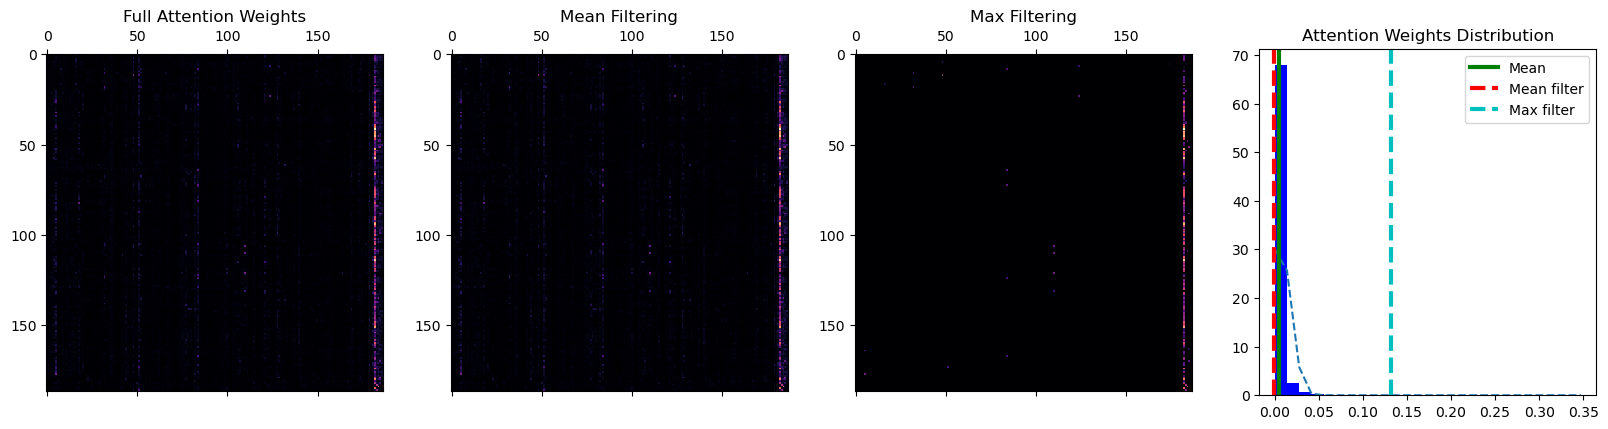


Document ID:  4 -- #Sentences:  230
Source text:
 ['As we have previously reported, 911 services have evolved from basic 911—which provided Americans with a universally recognized emergency number—to Enhanced 911 which also routes calls to the appropriate call center and provides information about the caller’s location and a call back number.', 'NG911 represents the next evolution in 911 services by using IP-based technology to deliver and process 911 traffic.', 'Under NG911, call centers will continue to receive voice calls and location information, but will also be able to accommodate emergency communications from the range of technologies in use today.', 'In addition, NG911 systems provide call centers with enhanced capabilities to route and transfer calls and data, which could improve call centers’ abilities to handle overflow calls and increase information sharing with first responders.', 'Generally speaking, 911 communications begin when a caller dials 911 using a landline, wire

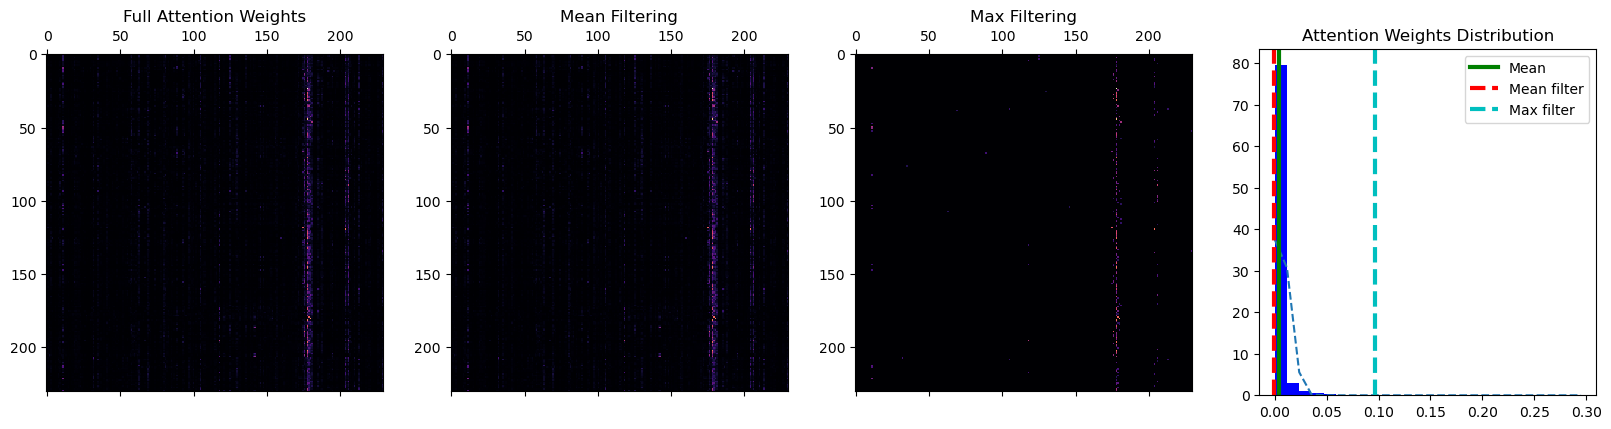

Done.

Filtering Attention Weights based on Max/Mean and Std Deviation
Done.


In [24]:
# Validation
filter = "mean"
filtered_matrices_v, total_nodes_v, total_edges_v, deletions_v = filtering_matrices(full_attn_weights_v, all_article_identifiers_v, df_val, print_samples=num_print,
                                                                                    degree_std=tolerance, with_filtering=filtering, filtering_type="mean", granularity=granularity)


##### ReLu

In [25]:
filtering=True
num_print= 5
tolerance = 0.5
granularity= "local"

model_name= "Extended_ReLu"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")



Loading Extended_ReLu (0.462 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_ReLu/Extended_ReLu-epoch=11-Val_f1-ma=0.46.ckpt
Model temperature 1

Trained Model Results on partition: Val
Val Acc: tensor(0.6132)
Val F1-score macro: tensor(0.4643)
Val F1-score for each class: tensor([0.7468, 0.1818])



Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  0 -- #Sentences:  67
Source text:
 ['Part of the Mariana Islands Archipelago, the CNMI is a chain of 14 islands in the western Pacific Ocean, just north of Guam and about 3,200 miles west of Hawaii.', 'The CNMI has a total population of 53,890, according to the CNMI’s 2016 Household, Income, and Expenditures Survey.', 'Almost 90 percent of the population (48,200) resided on the island of Saipan, with an additional 6 percent (3,056) on the island of Tinian and 5 percent (2,635) on the island of Rota.', 'The Consolidated Natural Resources Act of 2008 amended the U.S.– CNMI covenant to apply federal immigration law to the CNMI after a transition period.', 'To provide for an orderly transition from the CNMI immigration system to the U.S. federal immigration system under the immigration laws of the United States, DHS established the CW program in 2011.', 'Under the program, foreign workers are able to obtain, th

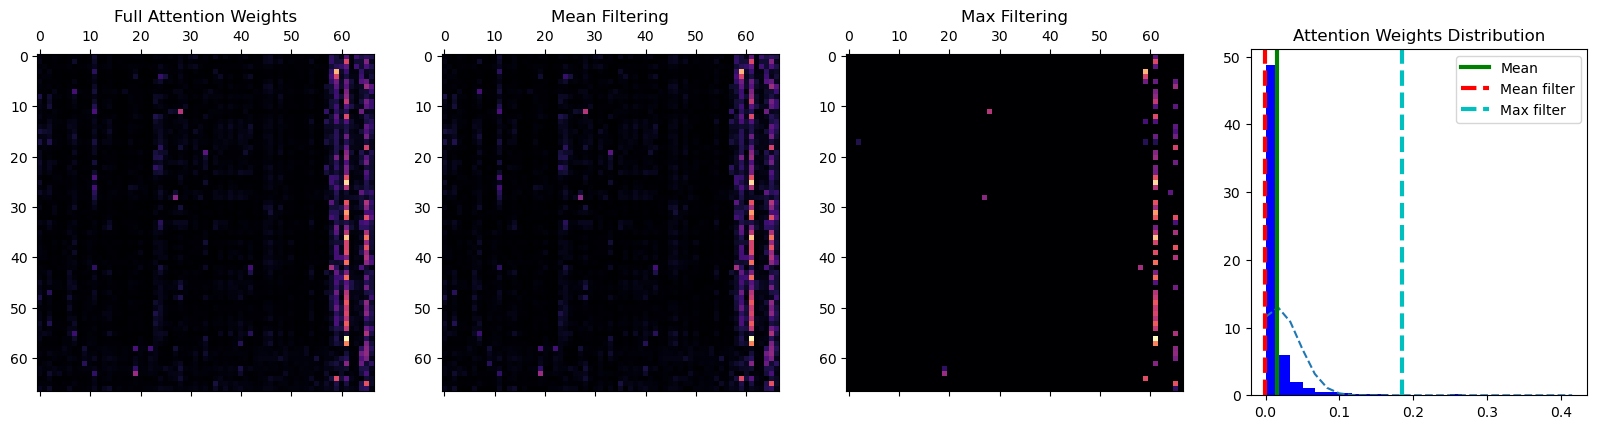


Document ID:  1 -- #Sentences:  148
Source text:
 ['The U.S. pipeline network includes both interstate and intrastate pipelines, the vast majority of which fall into the latter category: Interstate pipelines: Interstate pipelines are primarily large-volume transmission pipelines that carry gas or hazardous liquid–sometimes over hundreds of miles—to communities and large-volume users (e.g., factories).', 'At the start of 2017, there were about 340,000 miles of interstate transmission pipelines nationwide.', 'Newly tapped domestic gas and oil deposits have resulted in an increase in the existing pipeline infrastructure to transport natural gas and oil.', 'Intrastate pipelines: Intrastate pipelines are primarily composed of gas distribution and some transmission pipelines that transport natural gas pipelines to residential, commercial, and industrial customers.', 'As of 2015, there were about 2.2 million miles of distribution pipelines nationwide.', 'In addition, an estimated 18,000 mile

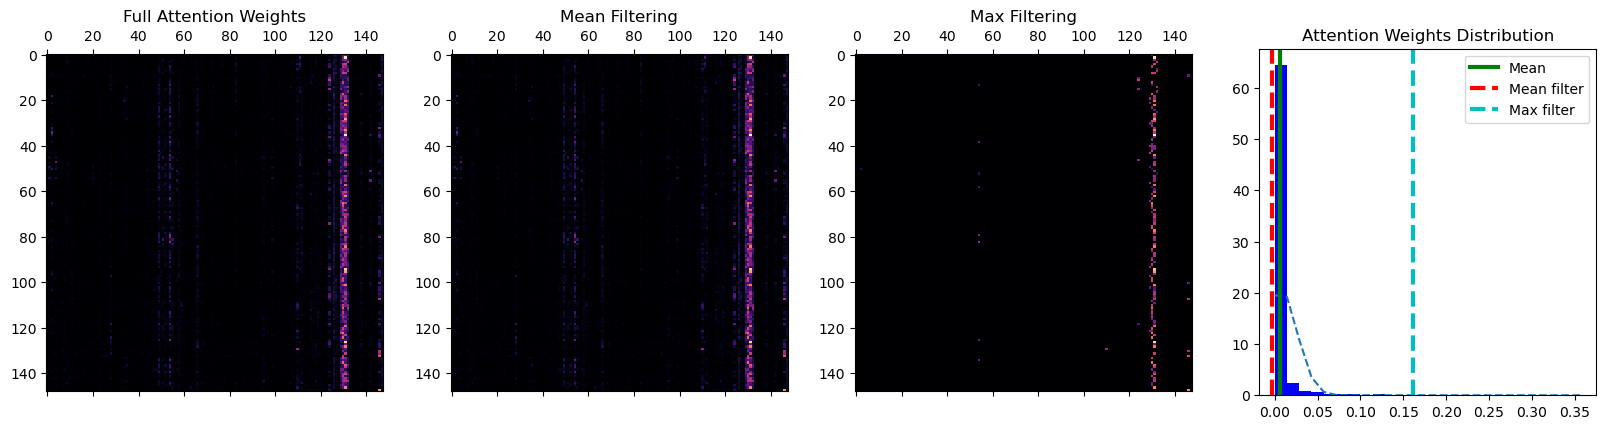


Document ID:  2 -- #Sentences:  137
Source text:
 ['VA’s mission is to promote the health, welfare, and dignity of all veterans in recognition of their service to the nation by ensuring that they receive medical care, benefits, social support, and lasting memorials.', 'In carrying out this mission, the department operates one of the largest health care delivery systems in the United States, providing health care services to approximately 9 million veterans throughout the United States, Philippines, Virgin Islands, Puerto Rico, American Samoa, and Guam.', 'In 2015, we designated VA health care as a high-risk area for the federal government, and we continue to be concerned about the department’s ability to ensure that its resources are being used cost-effectively and efficiently to improve veterans’ timely access to health care.', 'In part, we identified limitations in the capacity of VA’s existing IT systems, including the outdated, inefficient nature of certain systems and a lack of s

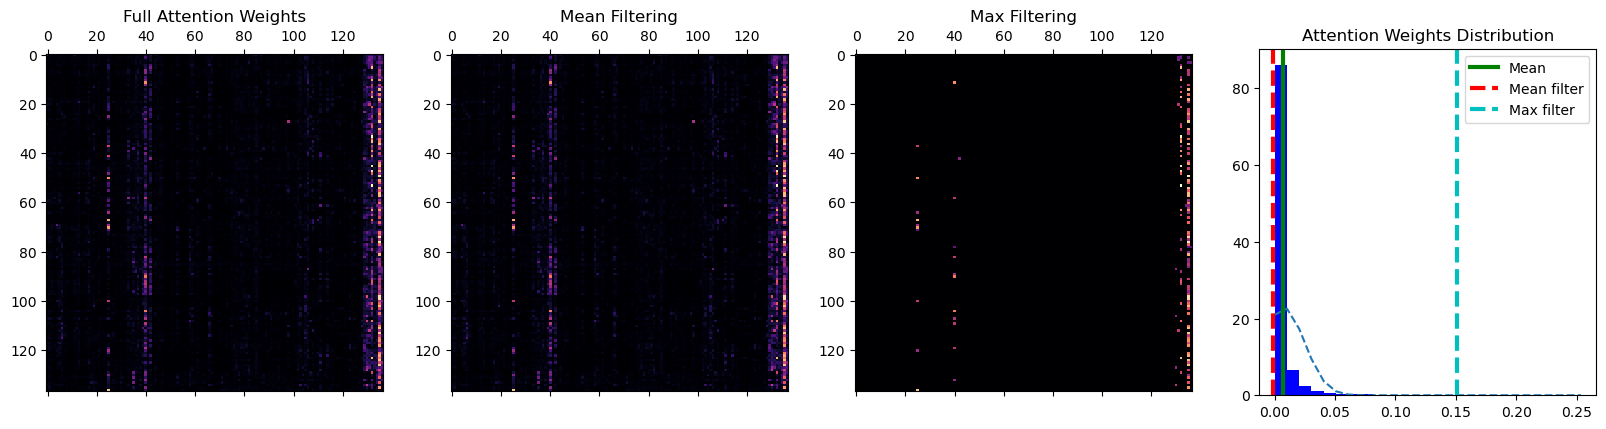


Document ID:  3 -- #Sentences:  187
Source text:
 ['JWST is envisioned to be a large deployable space telescope, optimized for infrared observations, and the scientific successor to the aging Hubble Space Telescope.', 'JWST is being designed for a 5-year mission to find the first stars, study planets in other solar systems to search for the building blocks of life elsewhere in the universe, and trace the evolution of galaxies from their beginning to their current formation.', 'JWST is intended to operate in an orbit approximately 1.5 million kilometers—or 1 million miles—from the Earth.', 'With a 6.5-meter primary mirror, JWST is expected to operate at about 100 times the sensitivity of the Hubble Space Telescope.', 'JWST’s science instruments are designed to observe very faint infrared sources and therefore are required to operate at extremely cold temperatures.', 'To help keep these instruments cold, a multi-layered tennis court-sized sunshield is being developed to protect the mirr

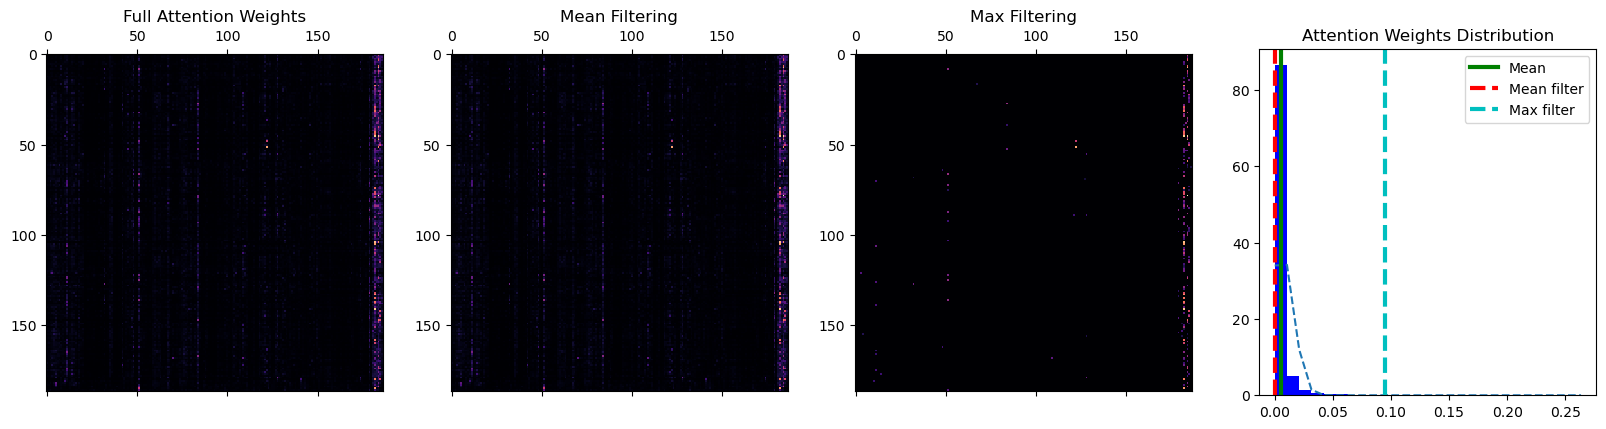


Document ID:  4 -- #Sentences:  230
Source text:
 ['As we have previously reported, 911 services have evolved from basic 911—which provided Americans with a universally recognized emergency number—to Enhanced 911 which also routes calls to the appropriate call center and provides information about the caller’s location and a call back number.', 'NG911 represents the next evolution in 911 services by using IP-based technology to deliver and process 911 traffic.', 'Under NG911, call centers will continue to receive voice calls and location information, but will also be able to accommodate emergency communications from the range of technologies in use today.', 'In addition, NG911 systems provide call centers with enhanced capabilities to route and transfer calls and data, which could improve call centers’ abilities to handle overflow calls and increase information sharing with first responders.', 'Generally speaking, 911 communications begin when a caller dials 911 using a landline, wire

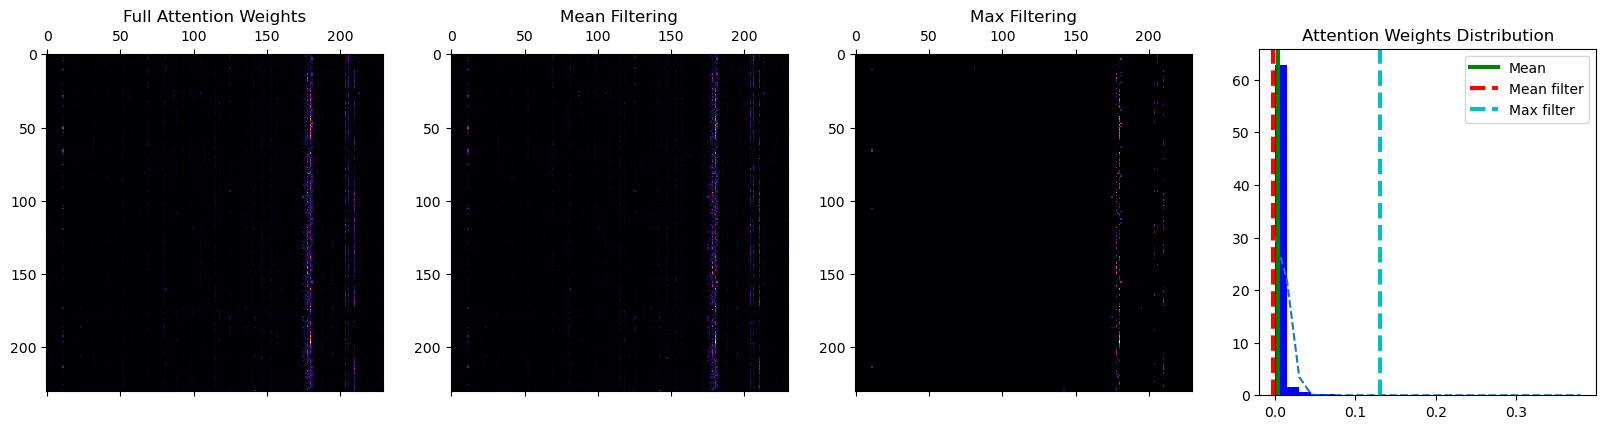

Done.


In [26]:
# Validation
filter = "mean"
filtered_matrices_v, total_nodes_v, total_edges_v, deletions_v = filtering_matrices(full_attn_weights_v, all_article_identifiers_v, df_val, print_samples=num_print,
                                                                                    degree_std=tolerance, with_filtering=filtering, filtering_type="mean", granularity=granularity)


#### Checking matrices from 2-layer MHA - Sigmoid

In [16]:
filtering=True
num_print= 5
tolerance = 0.5
granularity= "local"
model_name= "Extended_Sigmoid"
num_classes = 2
setting_file= "config/Summarizer/multi_summarizer_sigmoid.yaml"

tempo= df_logger.where(df_logger['Setting']==setting_file).dropna()
print (tempo.head())

path_checkpoint, model_score = retrieve_parameters(model_name, tempo)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer_extended.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

               Model                                               Path  \
26  Extended_Sigmoid  /scratch/mbugueno/HomoGraphs_GovReports/Extend...   
29  Extended_Sigmoid  /scratch/mbugueno/HomoGraphs_GovReports/Extend...   
28  Extended_Sigmoid  /scratch/mbugueno/HomoGraphs_GovReports/Extend...   
25  Extended_Sigmoid  /scratch/mbugueno/HomoGraphs_GovReports/Extend...   
27  Extended_Sigmoid  /scratch/mbugueno/HomoGraphs_GovReports/Extend...   

       Score  Test score                                          Setting  \
26  0.481313    0.483012  config/Summarizer/multi_summarizer_sigmoid.yaml   
29  0.469632    0.471594  config/Summarizer/multi_summarizer_sigmoid.yaml   
28  0.463394    0.459358  config/Summarizer/multi_summarizer_sigmoid.yaml   
25  0.450400    0.445132  config/Summarizer/multi_summarizer_sigmoid.yaml   
27  0.435068    0.430478  config/Summarizer/multi_summarizer_sigmoid.yaml   

    Stop epoch  Temperature  Training_time    Total_time  
26        18.0          1.0

In [17]:
preds_v, full_attn_weights_v, all_labels_v, all_doc_ids_v, all_article_identifiers_v = model_lightning.predict(loader_val, cpu_store=False)
acc_v, f1_all_v = eval_results(preds_v, all_labels_v, num_classes, "Val")


Trained Model Results on partition: Val
Val Acc: tensor(0.6440)
Val F1-score macro: tensor(0.4826)
Val F1-score for each class: tensor([0.7716, 0.1936])



Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  0 -- #Sentences:  67
Source text:
 ['Part of the Mariana Islands Archipelago, the CNMI is a chain of 14 islands in the western Pacific Ocean, just north of Guam and about 3,200 miles west of Hawaii.', 'The CNMI has a total population of 53,890, according to the CNMI’s 2016 Household, Income, and Expenditures Survey.', 'Almost 90 percent of the population (48,200) resided on the island of Saipan, with an additional 6 percent (3,056) on the island of Tinian and 5 percent (2,635) on the island of Rota.', 'The Consolidated Natural Resources Act of 2008 amended the U.S.– CNMI covenant to apply federal immigration law to the CNMI after a transition period.', 'To provide for an orderly transition from the CNMI immigration system to the U.S. federal immigration system under the immigration laws of the United States, DHS established the CW program in 2011.', 'Under the program, foreign workers are able to obtain, th

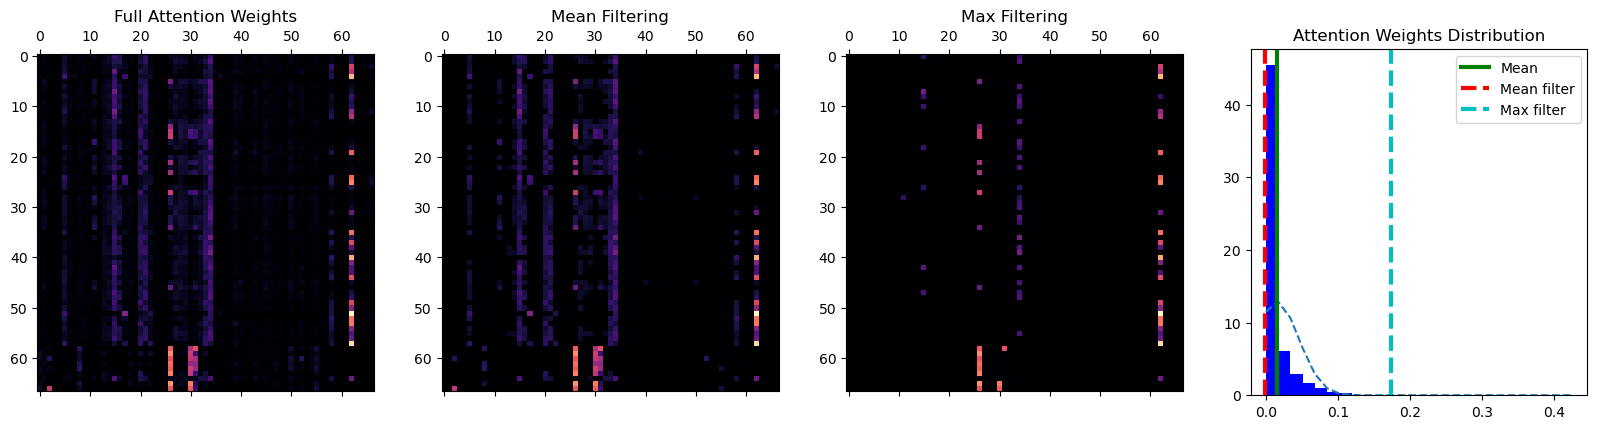


Document ID:  1 -- #Sentences:  148
Source text:
 ['The U.S. pipeline network includes both interstate and intrastate pipelines, the vast majority of which fall into the latter category: Interstate pipelines: Interstate pipelines are primarily large-volume transmission pipelines that carry gas or hazardous liquid–sometimes over hundreds of miles—to communities and large-volume users (e.g., factories).', 'At the start of 2017, there were about 340,000 miles of interstate transmission pipelines nationwide.', 'Newly tapped domestic gas and oil deposits have resulted in an increase in the existing pipeline infrastructure to transport natural gas and oil.', 'Intrastate pipelines: Intrastate pipelines are primarily composed of gas distribution and some transmission pipelines that transport natural gas pipelines to residential, commercial, and industrial customers.', 'As of 2015, there were about 2.2 million miles of distribution pipelines nationwide.', 'In addition, an estimated 18,000 mile

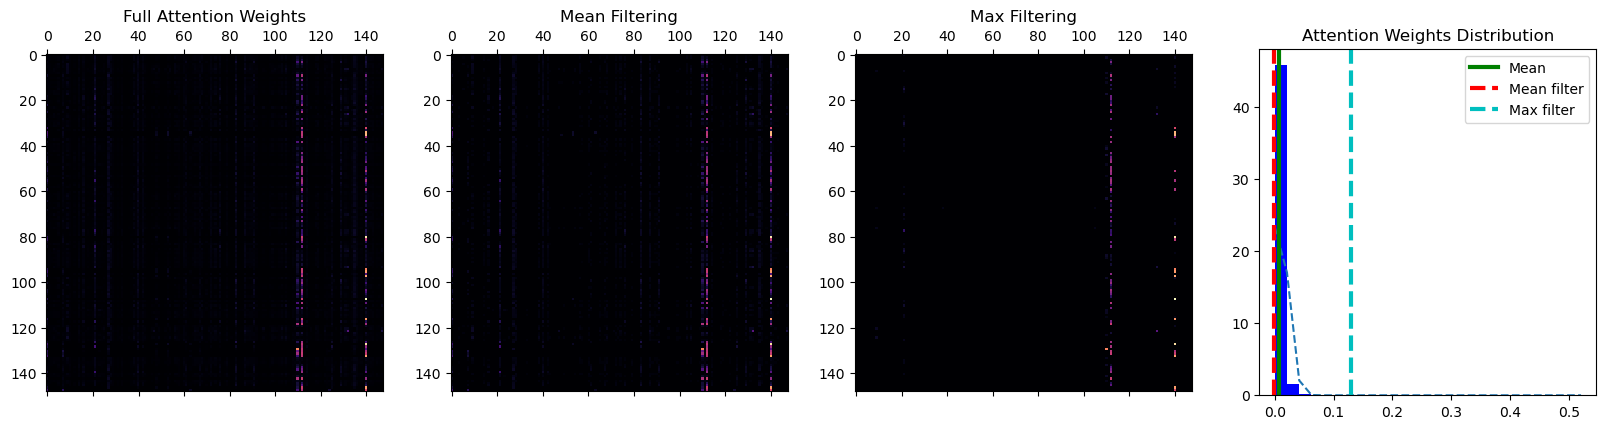


Document ID:  2 -- #Sentences:  137
Source text:
 ['VA’s mission is to promote the health, welfare, and dignity of all veterans in recognition of their service to the nation by ensuring that they receive medical care, benefits, social support, and lasting memorials.', 'In carrying out this mission, the department operates one of the largest health care delivery systems in the United States, providing health care services to approximately 9 million veterans throughout the United States, Philippines, Virgin Islands, Puerto Rico, American Samoa, and Guam.', 'In 2015, we designated VA health care as a high-risk area for the federal government, and we continue to be concerned about the department’s ability to ensure that its resources are being used cost-effectively and efficiently to improve veterans’ timely access to health care.', 'In part, we identified limitations in the capacity of VA’s existing IT systems, including the outdated, inefficient nature of certain systems and a lack of s

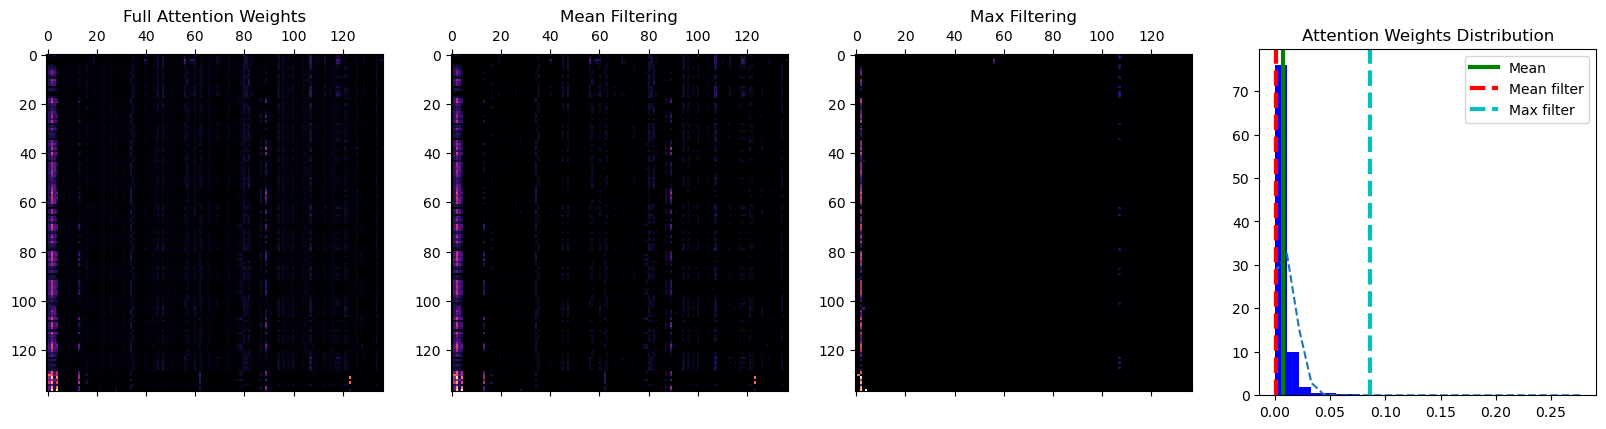


Document ID:  3 -- #Sentences:  187
Source text:
 ['JWST is envisioned to be a large deployable space telescope, optimized for infrared observations, and the scientific successor to the aging Hubble Space Telescope.', 'JWST is being designed for a 5-year mission to find the first stars, study planets in other solar systems to search for the building blocks of life elsewhere in the universe, and trace the evolution of galaxies from their beginning to their current formation.', 'JWST is intended to operate in an orbit approximately 1.5 million kilometers—or 1 million miles—from the Earth.', 'With a 6.5-meter primary mirror, JWST is expected to operate at about 100 times the sensitivity of the Hubble Space Telescope.', 'JWST’s science instruments are designed to observe very faint infrared sources and therefore are required to operate at extremely cold temperatures.', 'To help keep these instruments cold, a multi-layered tennis court-sized sunshield is being developed to protect the mirr

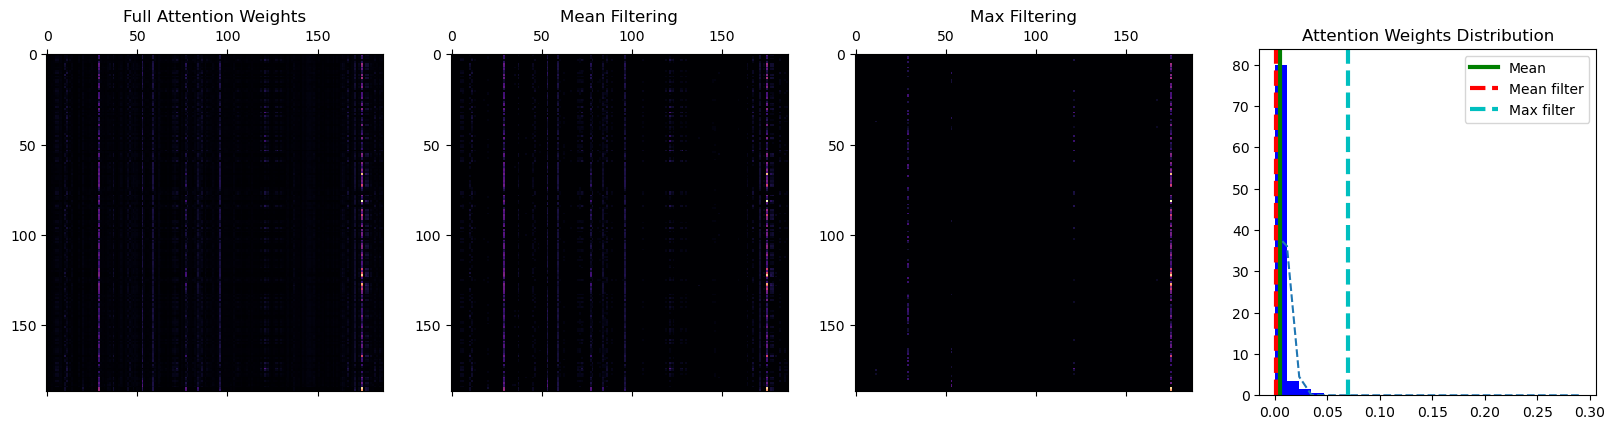


Document ID:  4 -- #Sentences:  230
Source text:
 ['As we have previously reported, 911 services have evolved from basic 911—which provided Americans with a universally recognized emergency number—to Enhanced 911 which also routes calls to the appropriate call center and provides information about the caller’s location and a call back number.', 'NG911 represents the next evolution in 911 services by using IP-based technology to deliver and process 911 traffic.', 'Under NG911, call centers will continue to receive voice calls and location information, but will also be able to accommodate emergency communications from the range of technologies in use today.', 'In addition, NG911 systems provide call centers with enhanced capabilities to route and transfer calls and data, which could improve call centers’ abilities to handle overflow calls and increase information sharing with first responders.', 'Generally speaking, 911 communications begin when a caller dials 911 using a landline, wire

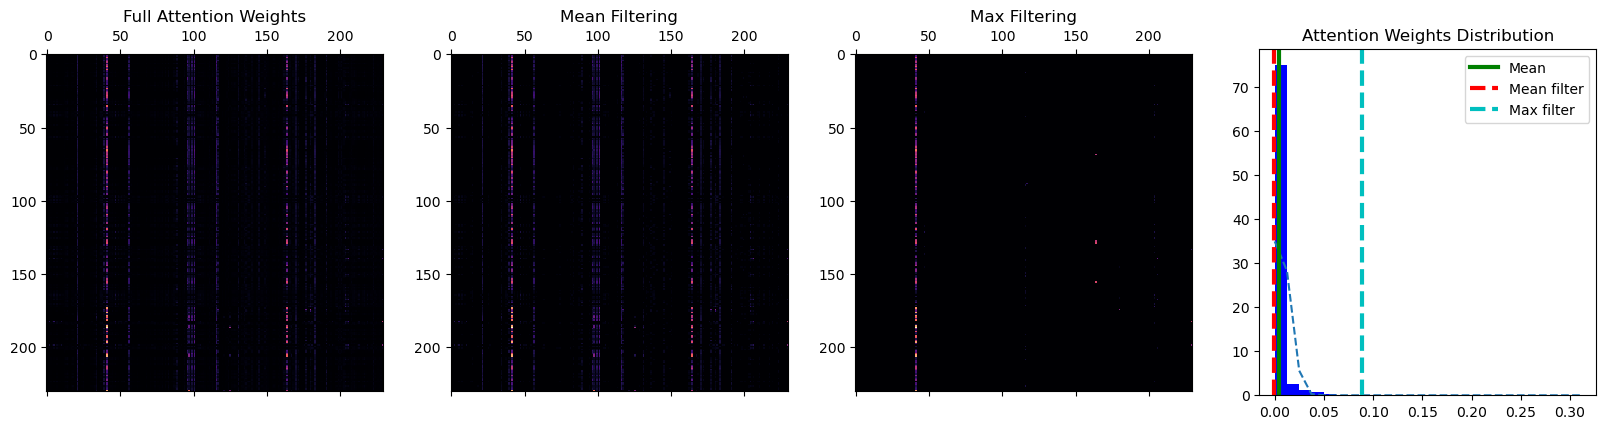

Done.


In [18]:
# Validation
filter = "mean"
filtered_matrices_v, total_nodes_v, total_edges_v, deletions_v = filtering_matrices(full_attn_weights_v, all_article_identifiers_v, df_val, print_samples=num_print,
                                                                                    degree_std=tolerance, with_filtering=filtering, filtering_type="mean", granularity=granularity)


### Creating Files for PyGeo Datasets + Batch size 1

In [28]:
#create loader from existing sentence vocabulary
loader_train, loader_val, loader_test, _ , _ , _, _ = create_loaders(df_train, df_test, 1000, 1, df_val=df_val, 
                                                                     task="summarization", tokenizer_from_scratch=False, path_ckpt=in_path)

### crear el filename como antes

In [ ]:
filtering=True
num_print= 5
tolerance = 0.5
granularity= "local"
model_name= "Extended_Sigmoid"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

In [10]:
path_root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/Attention/mean"
partition = "TRAIN"
accs_tr, f1s_tr = model_lightning.predict_to_file(loader_train, saving_file=True, filename="predict_train_documents.csv", path_root=path_root)
print ("["+partition+"] Avg. Acc:", torch.tensor(accs_tr).mean().item())
print ("["+partition+"] Avg. F1-score:", torch.stack(f1s_tr, dim=0).mean(dim=0).numpy())


Creating files for PyG dataset in: /scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/Attention/mean/raw/


100%|██████████| 17482/17482 [6:04:28<00:00,  1.25s/it]  

Avg. Acc on partition: 0.5859920382499695
Avg. F1 on partition: [0.68557984 0.19008233]


In [94]:
path_root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/Attention/mean"
partition = "VAL"
accs, f1s = model_lightning.predict_to_file(loader_val, saving_file=True, filename="predict_val_documents.csv", path_root=path_root)
print ("["+partition+"] Avg. Acc:", torch.tensor(accs_tr).mean().item())
print ("["+partition+"] Avg. F1-score:", torch.stack(f1s_tr, dim=0).mean(dim=0).numpy())


Creating files for PyG dataset in: /scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/Attention/mean/raw/
Avg. Acc on partition: 0.5406537055969238
Avg. F1 on partition: [0.64088166 0.19612125]


In [93]:
path_root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/Attention/mean"
partition = "TEST"
accs, f1s = model_lightning.predict_to_file(loader_test, saving_file=True, filename="predict_test_documents.csv", path_root=path_root)
print ("["+partition+"] Avg. Acc:", torch.tensor(accs_tr).mean().item())
print ("["+partition+"] Avg. F1-score:", torch.stack(f1s_tr, dim=0).mean(dim=0).numpy())

Avg. Acc on partition: 0.5400264263153076
Avg. F1 on partition: [0.63772166 0.20826617]


In [6]:
from torch_geometric.data import Data, Dataset
import torch
import os
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from eval_models import filtering_matrix
from base_model import retrieve_from_dict
from data_loaders import clean_tokenization_sent
from graph_data_loaders import AttentionGraphs_Sum

##### Creating Graph Objects

In [10]:
path_root = "/scratch/datasets/AttnGraphs_GovReports/Extended_Anneal/Attention/max"

filtering=True
num_print= 5
tolerance = 0.5
granularity= "local" 
model_name= "Extended_Anneal"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHASummarizer.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)



Loading Extended_Anneal (0.456 ) from: /scratch/mbugueno/HomoGraphs_GovReports/Extended_Anneal/Extended_Anneal-epoch=05-Val_f1-ma=0.46.ckpt


Model temperature 0.2691732647098334


In [11]:
#create loader from existing sentence vocabulary
loader_train, loader_val, loader_test, _ , _ , _, _ = create_loaders(df_train, df_test, 1000, 1, df_val=df_val, 
                                                                     task="summarization", tokenizer_from_scratch=False, path_ckpt=in_path)

In [11]:
# graphs train  #### CORRER
start_creation = time.time()
filename_train = "predict_train_documents.csv"
dataset_train = AttentionGraphs_Sum(path_root, filename_train, "max", loader_train, degree=0.5, model_ckpt=path_checkpoint, mode="train")
creation_train = time.time()-start_creation

Processing...


Creating Summarizer Model...
Attention method: softmax
Done.

[TRAIN] Creating Graphs Objects...


100%|██████████| 17482/17482 [12:54:36<00:00,  2.66s/it]   
Done!


In [26]:
# graphs val
start_creation = time.time()
filename_val = "predict_val_documents.csv"
dataset_val = AttentionGraphs_Sum(path_root, filename_val, "max", loader_val, degree=0.5, model_ckpt=path_checkpoint, mode="val")
creation_val = time.time()-start_creation

Processing...


Creating Summarizer Model...
Attention method: softmax
Done.

[VAL] Creating Graphs Objects...


100%|██████████| 970/970 [46:45<00:00,  2.89s/it]  
Done!


In [27]:
# graphs test
start_creation = time.time()
filename_test = "predict_test_documents.csv"
dataset_test = AttentionGraphs_Sum(path_root, filename_test, "max", loader_test, degree=0.5, model_ckpt=path_checkpoint, mode="test")
creation_test = time.time()-start_creation

Processing...


Creating Summarizer Model...
Attention method: softmax
Done.

[TEST] Creating Graphs Objects...

[TRAIN] Creating Graphs Objects...


100%|██████████| 972/972 [40:33<00:00,  2.50s/it]  
Done!
